In [1]:
pip install -r requirements-inv.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Importing necessary libraries
import kaggle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings

from scipy import stats
from scipy.stats import zscore, skew, kurtosis, shapiro, normaltest, f_oneway, probplot, uniform, randint
from sklearn.ensemble import IsolationForest, RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV, RidgeCV
from sklearn.model_selection import (
    train_test_split, 
    GridSearchCV, 
    RandomizedSearchCV, 
    cross_val_score, 
    learning_curve, 
    validation_curve, 
    KFold
)
from sklearn.metrics import (
    mean_squared_error, 
    mean_absolute_error, 
    r2_score, 
    mean_absolute_percentage_error, 
    make_scorer
)
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.stattools import adfuller

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, Input
from keras.optimizers import Adam
from keras.callbacks import History

from scikeras.wrappers import KerasRegressor

# Data Preparation

In [3]:
# Authenticate using the API token
kaggle.api.authenticate()

# Download and unzip the dataset
kaggle.api.dataset_download_files('mikhail1681/walmart-sales', path='/Users/joshuahellerman/Desktop/walmart-data', unzip=True)

# Load the dataset
df = pd.read_csv('/Users/joshuahellerman/Desktop/walmart-data/Walmart_sales.csv')

print(df.head())

print(df.dtypes)

Dataset URL: https://www.kaggle.com/datasets/mikhail1681/walmart-sales
   Store        Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
0      1  05-02-2010    1643690.90             0        42.31       2.572   
1      1  12-02-2010    1641957.44             1        38.51       2.548   
2      1  19-02-2010    1611968.17             0        39.93       2.514   
3      1  26-02-2010    1409727.59             0        46.63       2.561   
4      1  05-03-2010    1554806.68             0        46.50       2.625   

          CPI  Unemployment  
0  211.096358         8.106  
1  211.242170         8.106  
2  211.289143         8.106  
3  211.319643         8.106  
4  211.350143         8.106  
Store             int64
Date             object
Weekly_Sales    float64
Holiday_Flag      int64
Temperature     float64
Fuel_Price      float64
CPI             float64
Unemployment    float64
dtype: object


In [4]:
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')

print(df['Date'].dtype)

datetime64[ns]


In [5]:
total_missing_values = df.isnull().sum().sum()
print("Total missing values:", total_missing_values)

# Check for duplicates across all columns
duplicates = df.duplicated()

# Count the number of duplicates
num_duplicates = duplicates.sum()
print("Number of duplicates:", num_duplicates)

# Print rows with duplicates
if num_duplicates > 0:
    print("Duplicate rows:")
    print(df[duplicates])

# Check for total infinite values in numeric columns
numeric_cols = df.select_dtypes(include=[np.number])
total_infinite_values = numeric_cols.applymap(np.isinf).sum().sum()
print("Total infinite values:", total_infinite_values)

Total missing values: 0
Number of duplicates: 0
Total infinite values: 0


/var/folders/gb/h6936f_53x1_5xpd2267nqc80000gn/T/ipykernel_33557/2452198909.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  total_infinite_values = numeric_cols.applymap(np.isinf).sum().sum()


# Visual and Statistical Exploration of the Data

Descriptive Statistics:
       Weekly_Sales  Temperature   Fuel_Price          CPI  Unemployment
count  6.435000e+03  6435.000000  6435.000000  6435.000000   6435.000000
mean   1.046965e+06    60.663782     3.358607   171.578394      7.999151
std    5.643666e+05    18.444933     0.459020    39.356712      1.875885
min    2.099862e+05    -2.060000     2.472000   126.064000      3.879000
25%    5.533501e+05    47.460000     2.933000   131.735000      6.891000
50%    9.607460e+05    62.670000     3.445000   182.616521      7.874000
75%    1.420159e+06    74.940000     3.735000   212.743293      8.622000
max    3.818686e+06   100.140000     4.468000   227.232807     14.313000

Skewness and Kurtosis:
Weekly_Sales - Skewness: 0.6682059921068103, Kurtosis: 0.05216738979784408
Temperature - Skewness: -0.3366890954177888, Kurtosis: -0.6132571716629429
Fuel_Price - Skewness: -0.09613588414498364, Kurtosis: -1.1773954280947325
CPI - Skewness: 0.06347704896208373, Kurtosis: -1.8393163728228026
Une

/Users/joshuahellerman/anaconda3/envs/invall/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6435.
  res = hypotest_fun_out(*samples, **kwds)


Weekly_Sales - ADF Statistic: -4.624149498578294, p-value: 0.00011655869699901724
Temperature - ADF Statistic: -6.2518515238872885, p-value: 4.4343143704582346e-08
Fuel_Price - ADF Statistic: -14.336549359802447, p-value: 1.077635317026534e-26
CPI - ADF Statistic: -4.92391722080788, p-value: 3.1322557969043184e-05
Unemployment - ADF Statistic: -5.0817041274035955, p-value: 1.525645640003387e-05


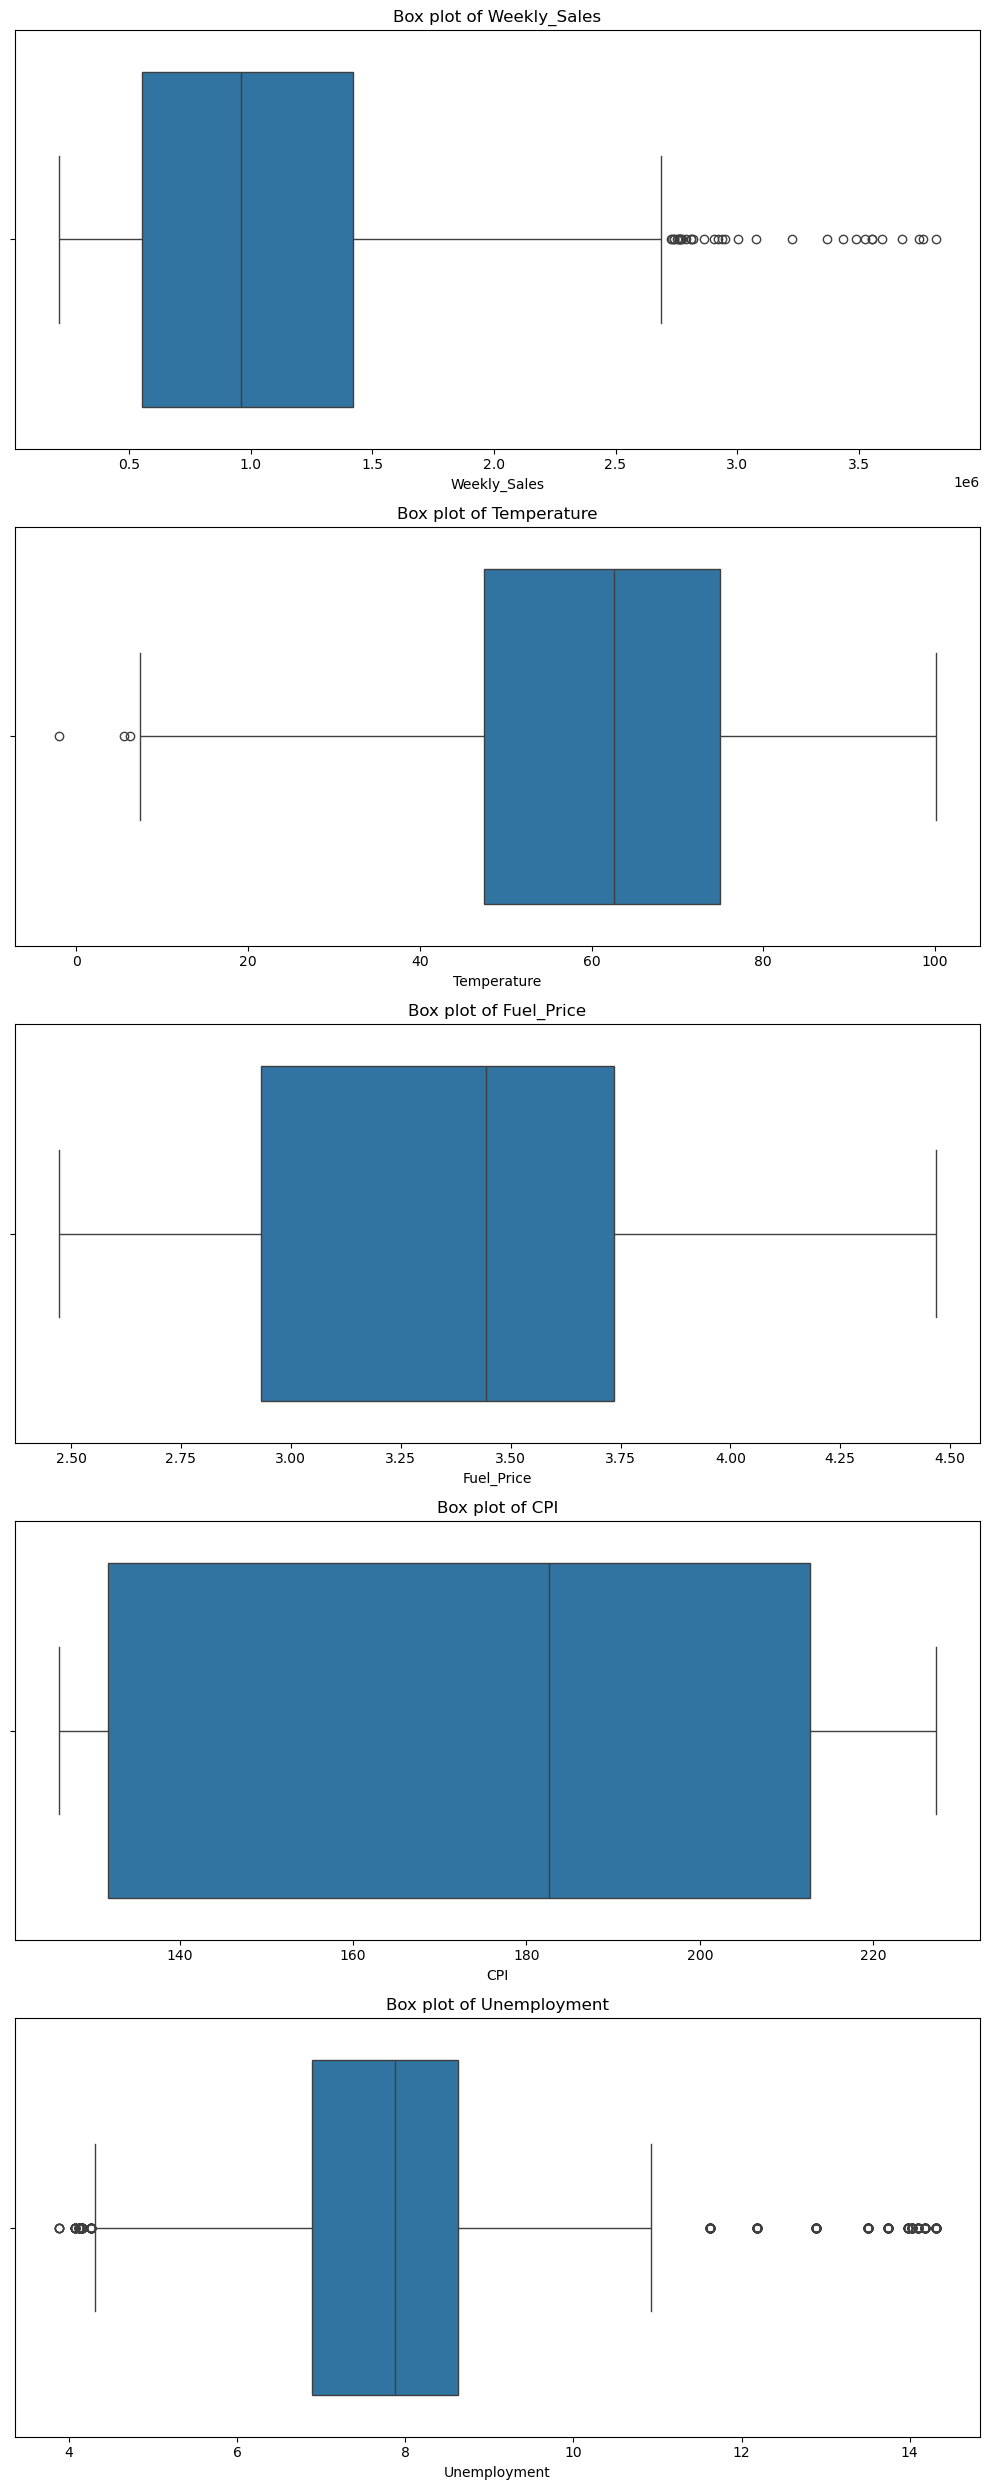

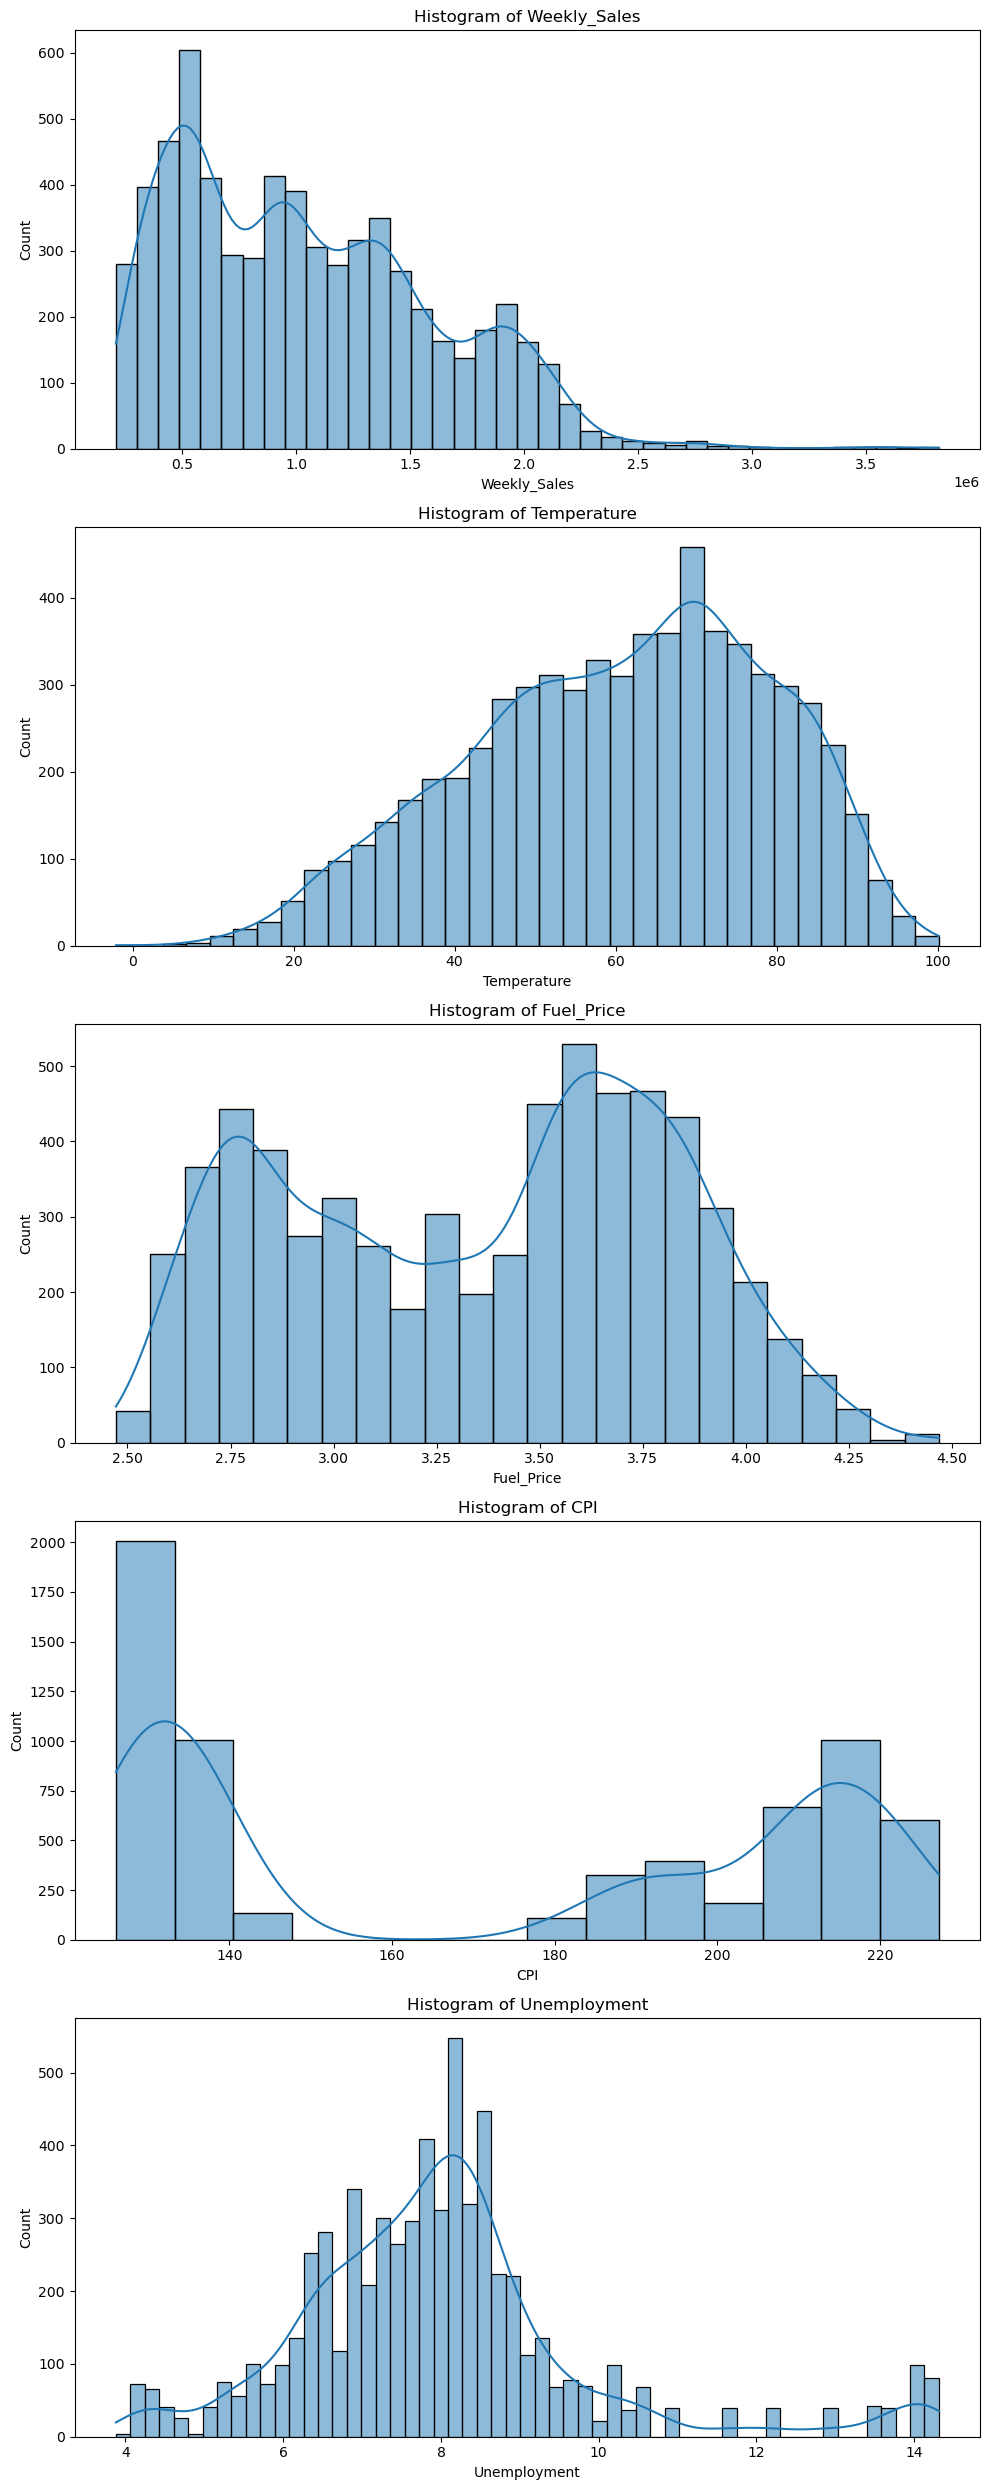

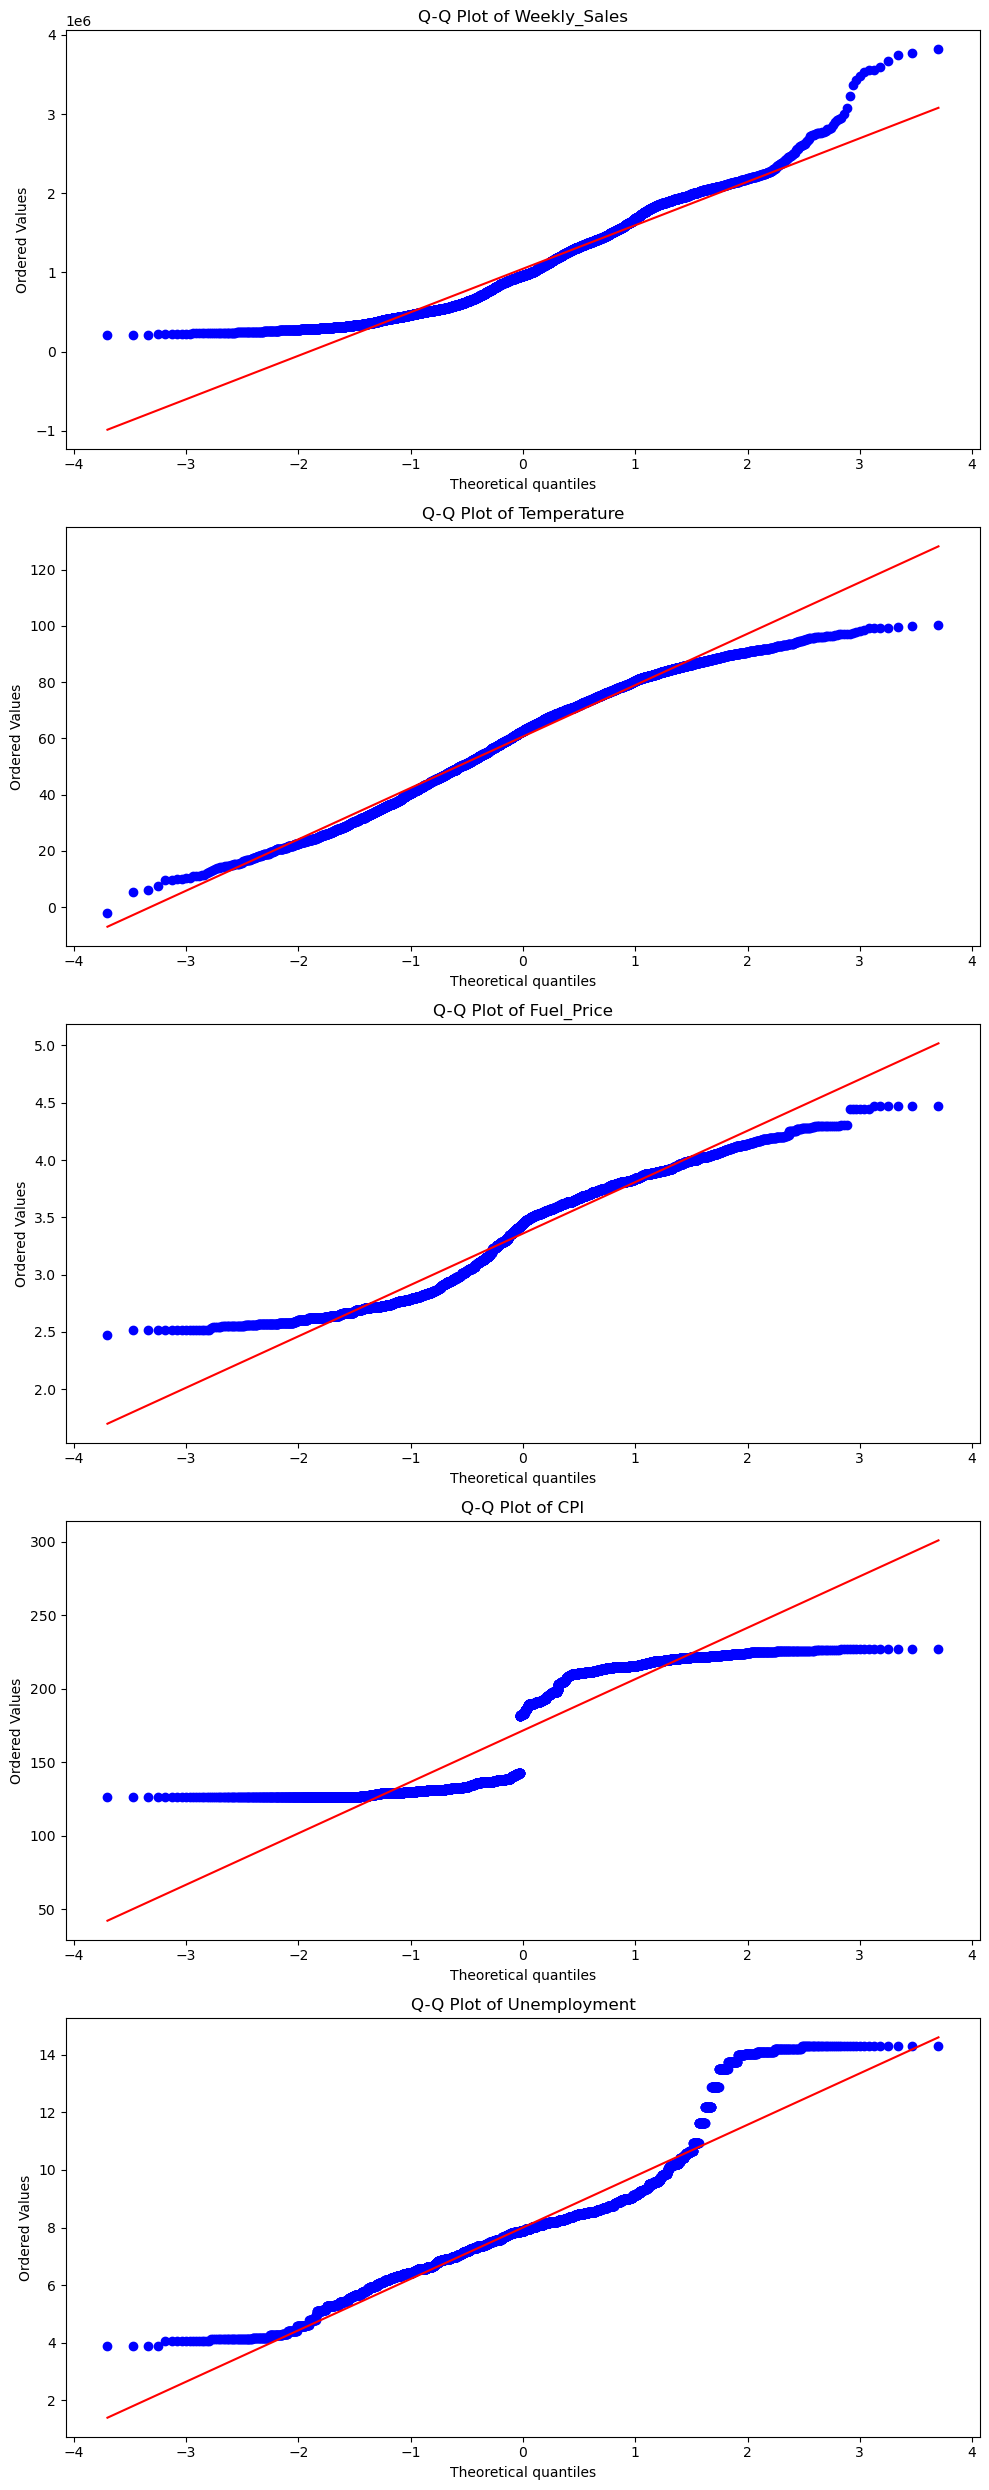

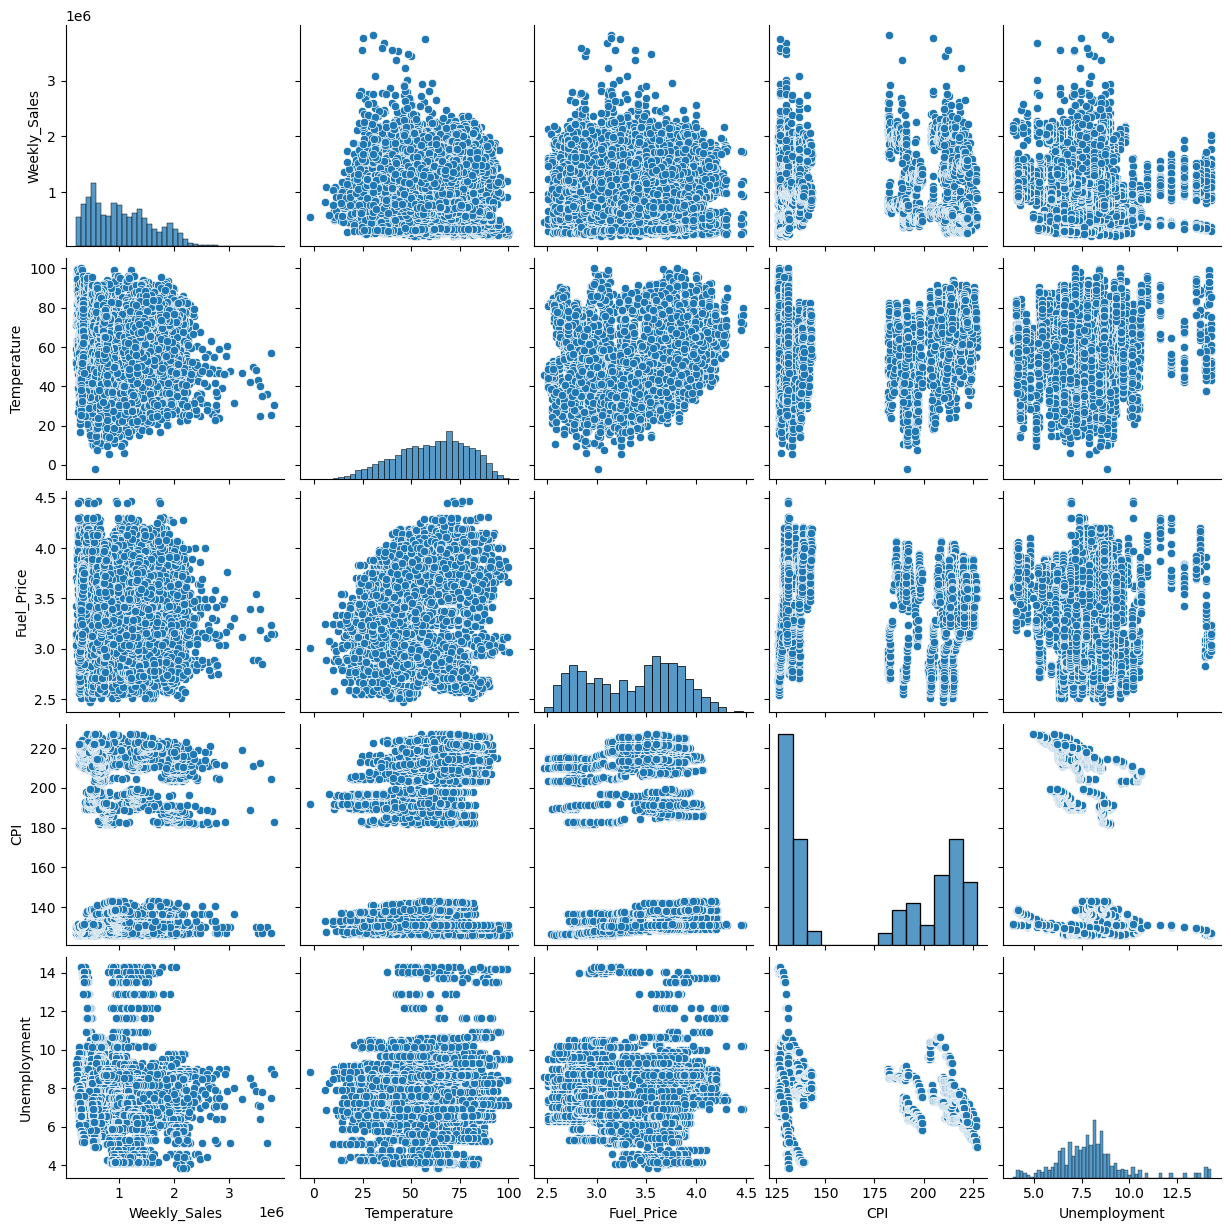

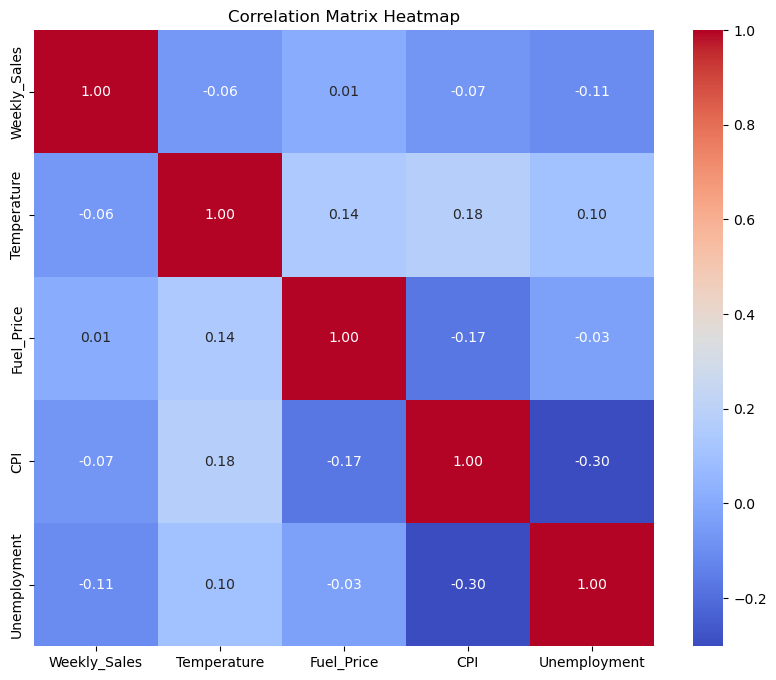

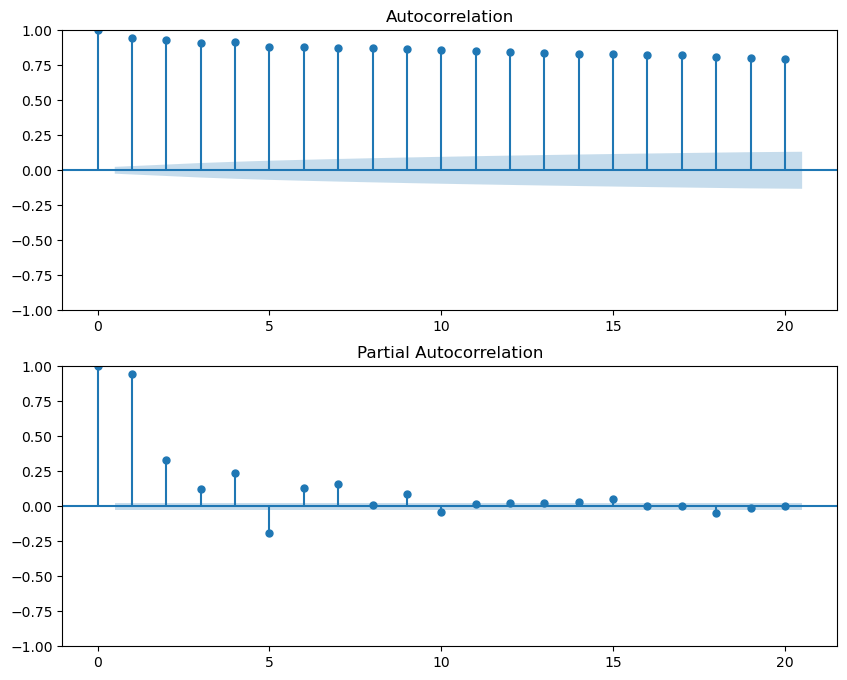

In [6]:
# Statistical Analysis

## Specify the columns to analyze
columns = ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']

## Filtering the dataframe to include only the columns of interest
df_test = df[columns]

## Descriptive Statistics
print("Descriptive Statistics:")
print(df_test.describe())

## Skewness and Kurtosis
print("\nSkewness and Kurtosis:")
for column in df_test.columns:
    print(f"{column} - Skewness: {skew(df_test[column].dropna())}, Kurtosis: {kurtosis(df_test[column].dropna())}")

## Normality Tests
print("\nNormality Tests:")
for column in df_test.columns:
    print(f"{column} - Shapiro-Wilk Test: {shapiro(df_test[column].dropna())}, D'Agostino's K-squared Test: {normaltest(df_test[column].dropna())}")

## Variance Inflation Factor (VIF) Calculation
## Separate features and target
target_column = 'Weekly_Sales'
X = df_test.drop(columns=[target_column])
y = df_test[target_column]

## Ensure target variable matches the filtered features
y = y.loc[X.index]

## Calculate VIF
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print("\nVariance Inflation Factor (VIF):")
print(vif_data)

## Stationarity Test (For Time Series Data)
print("\nStationarity Test (Augmented Dickey-Fuller Test):")
stationarity_tests = {col: adfuller(df_test[col].dropna()) for col in df_test.columns}
for column, test in stationarity_tests.items():
    print(f"{column} - ADF Statistic: {test[0]}, p-value: {test[1]}")

# Visual Exploration

## Box plots for visual inspection of outliers
fig, axes = plt.subplots(nrows=len(df_test.columns), ncols=1, figsize=(10, 5 * len(df_test.columns)))
for i, col in enumerate(df_test.columns):
    sns.boxplot(x=df_test[col], ax=axes[i])
    axes[i].set_title(f'Box plot of {col}')
plt.tight_layout()
plt.show()

## Histograms to check the distribution
fig, axes = plt.subplots(nrows=len(df_test.columns), ncols=1, figsize=(10, 5 * len(df_test.columns)))
for i, col in enumerate(df_test.columns):
    sns.histplot(df_test[col], kde=True, ax=axes[i])
    axes[i].set_title(f'Histogram of {col}')
plt.tight_layout()
plt.show()

## Q-Q plots for normality check
fig, axes = plt.subplots(nrows=len(df_test.columns), ncols=1, figsize=(10, 5 * len(df_test.columns)))
for i, col in enumerate(df_test.columns):
    probplot(df_test[col].dropna(), dist="norm", plot=axes[i])
    axes[i].set_title(f'Q-Q Plot of {col}')
plt.tight_layout()
plt.show()

## Pair Plot to visualize pairwise relationships
sns.pairplot(df_test)
plt.show()

## Heatmap of the correlation matrix
correlation_matrix = df_test.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix Heatmap')
plt.show()

## ACF and PACF plots for time series data (Example for 'Weekly_Sales')
fig, axes = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(df_test['Weekly_Sales'].dropna(), ax=axes[0], lags=20)
plot_pacf(df_test['Weekly_Sales'].dropna(), ax=axes[1], lags=20)
plt.show()

# Data Transformation

In [7]:
# Check number of stores in dataset

df['Store'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45])

### One-Hot Encoding

In [8]:
# One-hot encoding for store variable

# Creating the encoder instance
encoder = OneHotEncoder()

# Reshape(-1, 1) because the encoder expects a 2D array
encoded_features = encoder.fit_transform(df[['Store']])

# Convert the encoded features into a DataFrame
encoded_df = pd.DataFrame(encoded_features.toarray(), columns=encoder.get_feature_names_out(['Store']))

# Concatenate the original DataFrame with the new one
df = pd.concat([df, encoded_df], axis=1).drop('Store', axis=1)

print(df)

           Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
0    2010-02-05    1643690.90             0        42.31       2.572   
1    2010-02-12    1641957.44             1        38.51       2.548   
2    2010-02-19    1611968.17             0        39.93       2.514   
3    2010-02-26    1409727.59             0        46.63       2.561   
4    2010-03-05    1554806.68             0        46.50       2.625   
...         ...           ...           ...          ...         ...   
6430 2012-09-28     713173.95             0        64.88       3.997   
6431 2012-10-05     733455.07             0        64.89       3.985   
6432 2012-10-12     734464.36             0        54.47       4.000   
6433 2012-10-19     718125.53             0        56.47       3.969   
6434 2012-10-26     760281.43             0        58.85       3.882   

             CPI  Unemployment  Store_1  Store_2  Store_3  ...  Store_36  \
0     211.096358         8.106      1.0      0.0      0.0  

In [9]:
def transform_data(df, columns):
    # Create a new DataFrame for transformations
    df_transformed = df[columns].copy()

    # Apply log transformation to Weekly_Sales and Unemployment
    df_transformed['Weekly_Sales'] = np.log(df_transformed['Weekly_Sales'] + 1)
    df_transformed['Unemployment'] = np.log(df_transformed['Unemployment'] + 1)

    # Standardize Temperature, Fuel_Price, CPI, Weekly_Sales, and Unemployment
    scaler = StandardScaler()
    columns_to_standardize = ['Temperature', 'Fuel_Price', 'CPI', 'Weekly_Sales', 'Unemployment']
    df_transformed[columns_to_standardize] = scaler.fit_transform(df_transformed[columns_to_standardize])

    return df_transformed

# Example usage
df_transformed = transform_data(df, columns)
df_transformed.to_csv('processed_data.csv', index=False)
print(df_transformed.head())

   Weekly_Sales  Temperature  Fuel_Price       CPI  Unemployment
0      1.037892    -0.995136   -1.713800  1.004175      0.160732
1      1.036099    -1.201170   -1.766089  1.007880      0.160732
2      1.004763    -1.124178   -1.840166  1.009074      0.160732
3      0.776870    -0.760907   -1.737766  1.009849      0.160732
4      0.943387    -0.767955   -1.598328  1.010624      0.160732


### Principle Component Analysis

In [10]:
def apply_pca(df_transformed, target_column, variance_threshold=0.95):
    X_transformed = df_transformed.drop(columns=[target_column])
    y_transformed = df_transformed[target_column]
    pca = PCA(n_components=variance_threshold)
    X_pca = pca.fit_transform(X_transformed)

    # Create a DataFrame with the principal components
    pca_columns = [f'PC{i+1}' for i in range(X_pca.shape[1])]
    df_pca = pd.DataFrame(X_pca, columns=pca_columns)
    df_pca[target_column] = y_transformed.reset_index(drop=True)

    return df_pca

target_column = 'Weekly_Sales'
df_pca = apply_pca(df_transformed, target_column)
df_pca.to_csv('pca_data.csv', index=False)
print(df_pca.head())

        PC1       PC2       PC3       PC4  Weekly_Sales
0 -0.961774  1.715893 -0.961484 -0.409704      1.037892
1 -0.947336  1.907820 -0.911642 -0.485001      1.036099
2 -0.978688  1.893669 -0.987601 -0.418192      1.004763
3 -1.007084  1.548199 -1.070854 -0.294233      0.776870
4 -0.970882  1.467441 -0.983626 -0.357891      0.943387


### Visualization: Original vs Transformed Data

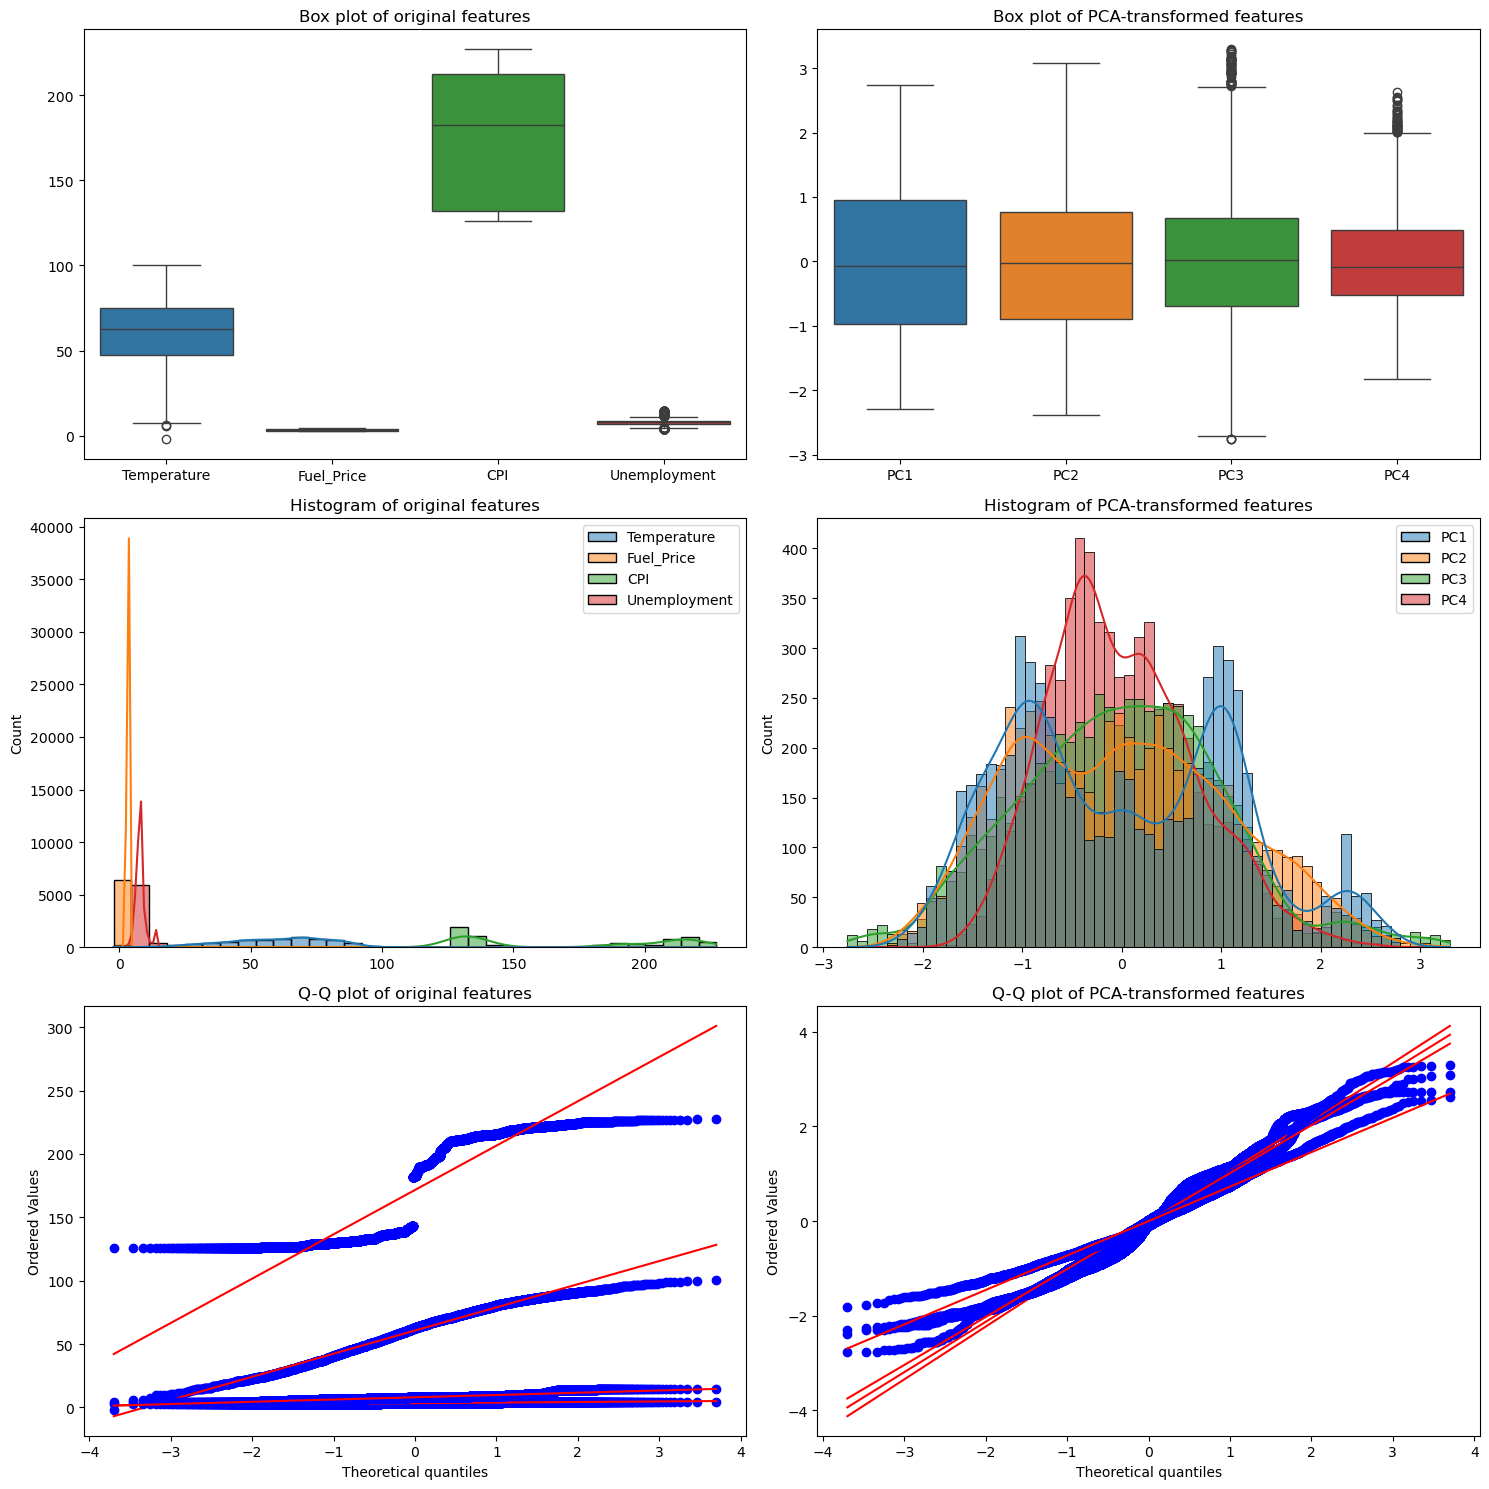

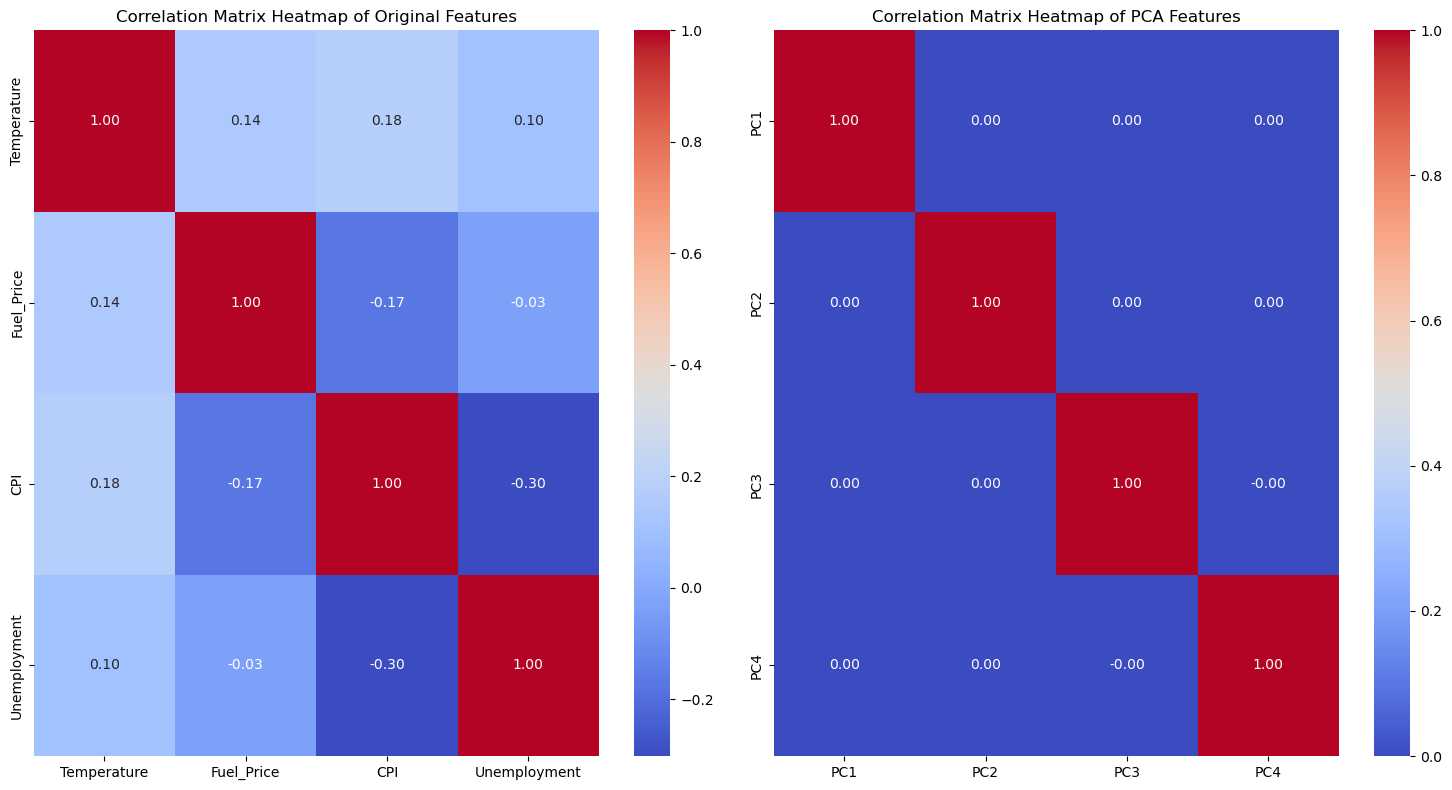

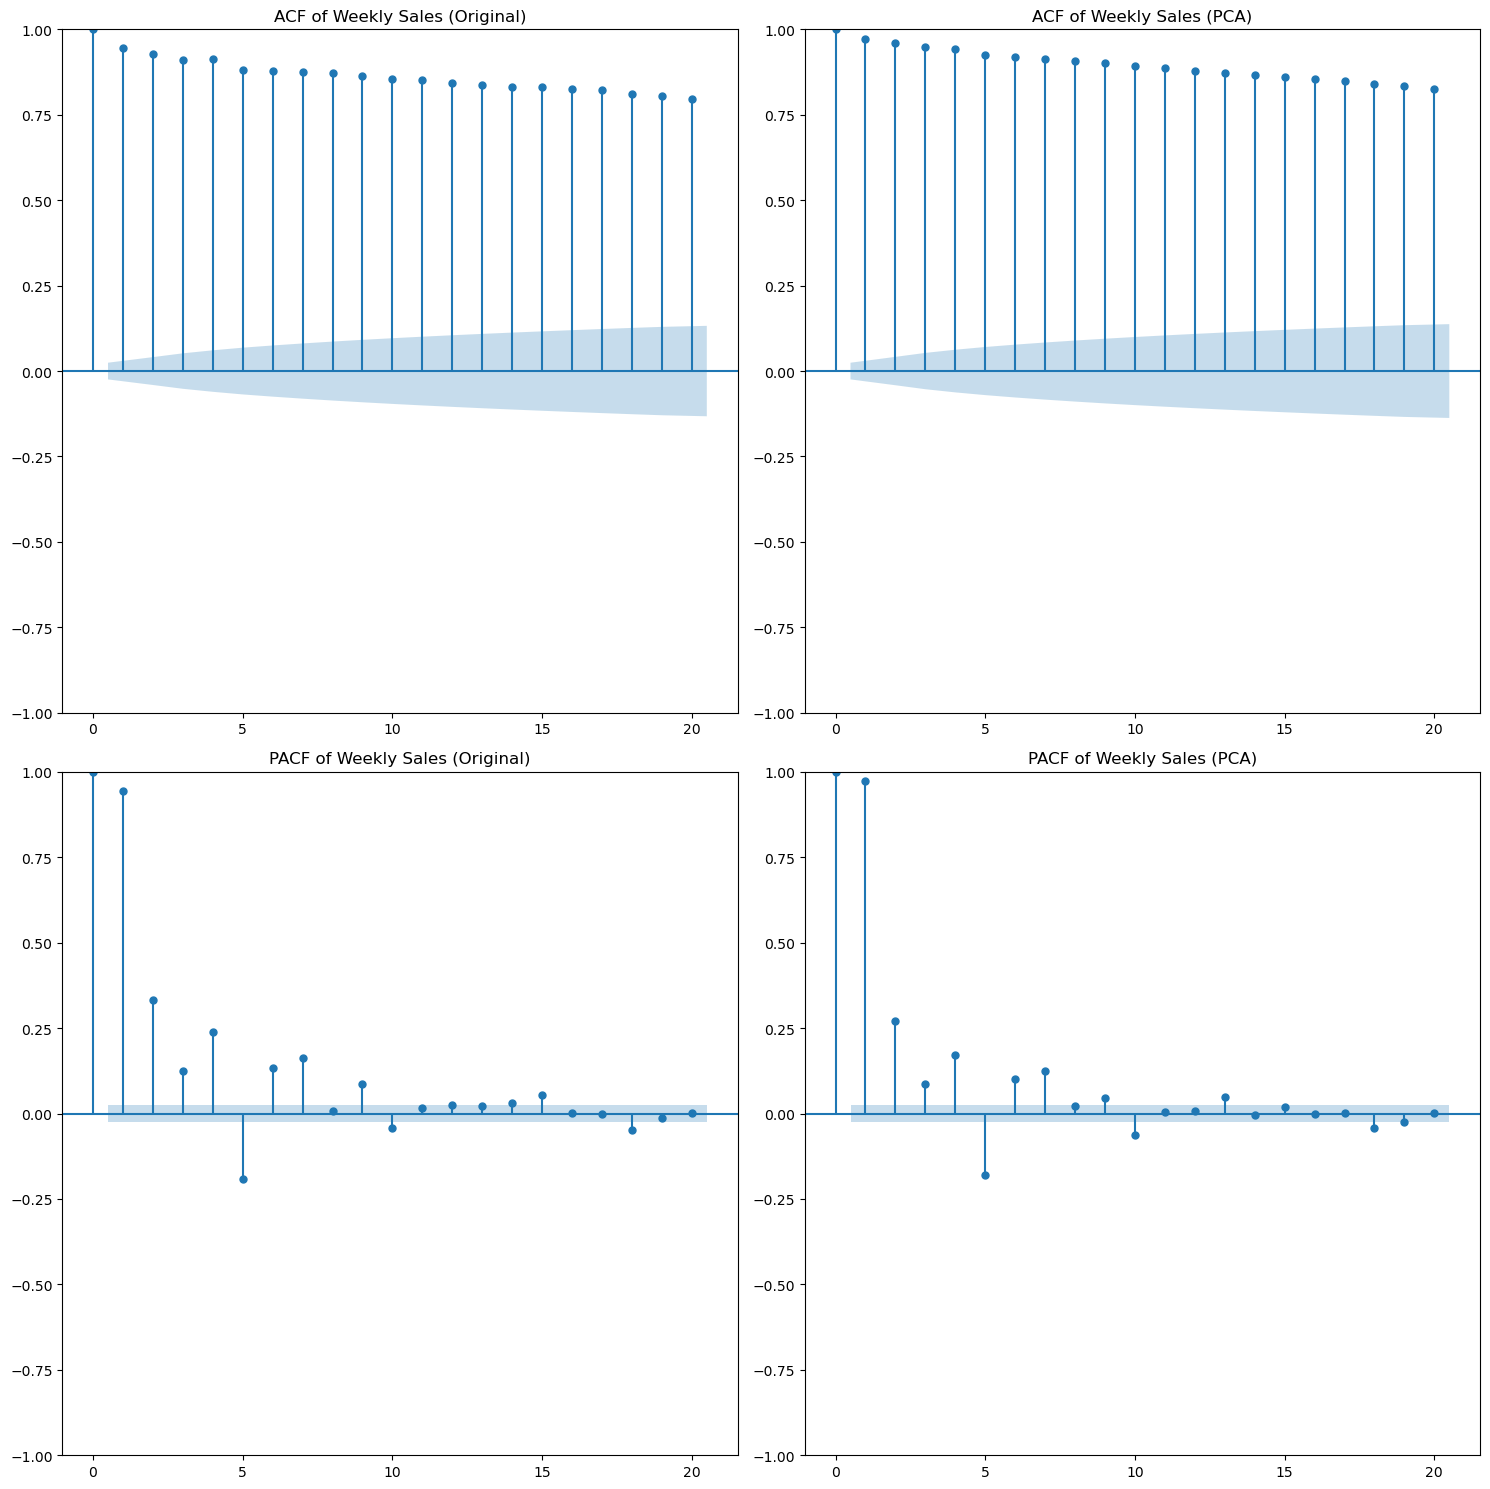

In [11]:
def plot_comparison(df, df_pca, target_column):
    fig, axes = plt.subplots(3, 2, figsize=(15, 15))

    # Box plots for visual inspection of outliers
    sns.boxplot(data=df.drop(columns=[target_column]), ax=axes[0, 0])
    axes[0, 0].set_title('Box plot of original features')

    sns.boxplot(data=df_pca.drop(columns=[target_column]), ax=axes[0, 1])
    axes[0, 1].set_title('Box plot of PCA-transformed features')

    # Histograms to check the distribution
    sns.histplot(data=df.drop(columns=[target_column]), kde=True, ax=axes[1, 0])
    axes[1, 0].set_title('Histogram of original features')

    sns.histplot(data=df_pca.drop(columns=[target_column]), kde=True, ax=axes[1, 1])
    axes[1, 1].set_title('Histogram of PCA-transformed features')

    # Q-Q plots for normality check
    for col in df.drop(columns=[target_column]).columns:
        probplot(df[col].dropna(), dist="norm", plot=axes[2, 0])
    axes[2, 0].set_title('Q-Q plot of original features')

    for col in df_pca.drop(columns=[target_column]).columns:
        probplot(df_pca[col].dropna(), dist="norm", plot=axes[2, 1])
    axes[2, 1].set_title('Q-Q plot of PCA-transformed features')

    plt.tight_layout()
    plt.show()

    # Correlation matrix heatmap
    fig, axes = plt.subplots(1, 2, figsize=(15, 8))
    correlation_matrix_original = df.drop(columns=[target_column]).corr()
    sns.heatmap(correlation_matrix_original, annot=True, cmap='coolwarm', fmt='.2f', ax=axes[0])
    axes[0].set_title('Correlation Matrix Heatmap of Original Features')

    correlation_matrix_pca = df_pca.drop(columns=[target_column]).corr()
    sns.heatmap(correlation_matrix_pca, annot=True, cmap='coolwarm', fmt='.2f', ax=axes[1])
    axes[1].set_title('Correlation Matrix Heatmap of PCA Features')

    plt.tight_layout()
    plt.show()

    # ACF and PACF plots for 'Weekly_Sales'
    fig, axes = plt.subplots(2, 2, figsize=(15, 15))
    plot_acf(df[target_column].dropna(), ax=axes[0, 0], lags=20)
    axes[0, 0].set_title('ACF of Weekly Sales (Original)')

    plot_pacf(df[target_column].dropna(), ax=axes[1, 0], lags=20)
    axes[1, 0].set_title('PACF of Weekly Sales (Original)')

    plot_acf(df_pca[target_column].dropna(), ax=axes[0, 1], lags=20)
    axes[0, 1].set_title('ACF of Weekly Sales (PCA)')

    plot_pacf(df_pca[target_column].dropna(), ax=axes[1, 1], lags=20)
    axes[1, 1].set_title('PACF of Weekly Sales (PCA)')

    plt.tight_layout()
    plt.show()

plot_comparison(df[columns], df_pca, 'Weekly_Sales')

# Prediction Model Evaluation

### Prepare Dataframe

In [12]:
df_pca.head()

PC1       PC2       PC3       PC4  Weekly_Sales
0 -0.961774  1.715893 -0.961484 -0.409704      1.037892
1 -0.947336  1.907820 -0.911642 -0.485001      1.036099
2 -0.978688  1.893669 -0.987601 -0.418192      1.004763
3 -1.007084  1.548199 -1.070854 -0.294233      0.776870
4 -0.970882  1.467441 -0.983626 -0.357891      0.943387

In [13]:
# Function to remove outliers based on Z-score for specified columns
def remove_outliers_zscore(df, columns, threshold=3):
    z_scores = np.abs(stats.zscore(df[columns]))
    df_cleaned = df[(z_scores < threshold).all(axis=1)]
    return df_cleaned

# Drop unnecessary columns from df, keeping only the date, holiday flag, and one-hot encoded columns
columns_to_keep = ['Date', 'Holiday_Flag']  # Start with the Date and Holiday_Flag columns
encoded_columns = [col for col in df.columns if col.startswith('Store_')]  # Add encoded columns
columns_to_keep.extend(encoded_columns)

df_cleaned = df[columns_to_keep]

# Add Day_of_Week and Month columns
df_cleaned['Month'] = df_cleaned['Date'].dt.month

# Merge df_cleaned with df_pca using suffixes to handle overlapping columns
df_pca_combined = df_pca.join(df_cleaned, how='inner', lsuffix='_pca', rsuffix='_cleaned')

# Now df_pca_combined includes PCA components, the holiday flag, and the one-hot encoded variables
df_pca_combined = df_pca_combined.reset_index(drop=True)

# Remove the Date column
df_pca_combined = df_pca_combined.drop(columns=['Date'])

# Remove outliers for PC3 and PC4
df_pca_combined = remove_outliers_zscore(df_pca_combined, ['PC3', 'PC4'])

print(df_pca_combined)

           PC1       PC2       PC3       PC4  Weekly_Sales  Holiday_Flag  \
0    -0.961774  1.715893 -0.961484 -0.409704      1.037892             0   
1    -0.947336  1.907820 -0.911642 -0.485001      1.036099             1   
2    -0.978688  1.893669 -0.987601 -0.418192      1.004763             0   
3    -1.007084  1.548199 -1.070854 -0.294233      0.776870             0   
4    -0.970882  1.467441 -0.983626 -0.357891      0.943387             0   
...        ...       ...       ...       ...           ...           ...   
6430  0.199428 -1.121562  0.334195 -1.033465     -0.381514             0   
6431  0.184511 -1.105683  0.323036 -1.020104     -0.333846             0   
6432  0.273926 -0.687530  0.567820 -1.298506     -0.331509             0   
6433  0.240408 -0.730026  0.483492 -1.219259     -0.369752             0   
6434  0.173042 -0.713073  0.317063 -1.077635     -0.272781             0   

      Store_1  Store_2  Store_3  Store_4  ...  Store_37  Store_38  Store_39  \
0       

/var/folders/gb/h6936f_53x1_5xpd2267nqc80000gn/T/ipykernel_33557/1675491077.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Month'] = df_cleaned['Date'].dt.month


In [14]:
df_pca_combined.columns

Index(['PC1', 'PC2', 'PC3', 'PC4', 'Weekly_Sales', 'Holiday_Flag', 'Store_1',
       'Store_2', 'Store_3', 'Store_4', 'Store_5', 'Store_6', 'Store_7',
       'Store_8', 'Store_9', 'Store_10', 'Store_11', 'Store_12', 'Store_13',
       'Store_14', 'Store_15', 'Store_16', 'Store_17', 'Store_18', 'Store_19',
       'Store_20', 'Store_21', 'Store_22', 'Store_23', 'Store_24', 'Store_25',
       'Store_26', 'Store_27', 'Store_28', 'Store_29', 'Store_30', 'Store_31',
       'Store_32', 'Store_33', 'Store_34', 'Store_35', 'Store_36', 'Store_37',
       'Store_38', 'Store_39', 'Store_40', 'Store_41', 'Store_42', 'Store_43',
       'Store_44', 'Store_45', 'Month'],
      dtype='object')

### Utility Functions

In [15]:
# Utility functions
def prepare_data(df, target_column):  
    # Prepare data for machine learning
    X = df.drop(columns=[target_column])
    y = df[target_column]
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def adjusted_r2_score(y_true, y_pred, X):
    n = len(y_true)
    p = X.shape[1]
    r2 = r2_score(y_true, y_pred)
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

def evaluate_model(y_true, y_pred, X, dataset_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    adj_r2 = adjusted_r2_score(y_true, y_pred, X)
    
    metrics = {
        'Dataset': dataset_name,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'R²': r2,
        'Adjusted R²': adj_r2,
        'Training Time': None  # Placeholder, will be updated in model scripts
    }
    return metrics

def plot_learning_curve(model, X_train, y_train):
    train_sizes, train_scores, val_scores = learning_curve(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    train_scores_mean = -train_scores.mean(axis=1)
    val_scores_mean = -val_scores.mean(axis=1)
    
    plt.figure()
    plt.plot(train_sizes, train_scores_mean, 'o-', label="Training score")
    plt.plot(train_sizes, val_scores_mean, 'o-', label="Cross-validation score")
    plt.title("Learning Curve")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

def plot_validation_curve(model, X_train, y_train, param_name, param_range):
    train_scores, val_scores = validation_curve(model, X_train, y_train, param_name=param_name, param_range=param_range, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    train_scores_mean = -train_scores.mean(axis=1)
    val_scores_mean = -val_scores.mean(axis=1)
    
    plt.figure()
    plt.plot(param_range, train_scores_mean, 'o-', label="Training score")
    plt.plot(param_range, val_scores_mean, 'o-', label="Cross-validation score")
    plt.title(f"Validation Curve for {param_name}")
    plt.xlabel(param_name)
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

def plot_residuals(y_true, y_pred):
    residuals = y_true - y_pred
    plt.figure()
    plt.scatter(y_pred, residuals)
    plt.hlines(0, xmin=y_pred.min(), xmax=y_pred.max(), linestyles='dashed')
    plt.xlabel("Predicted")
    plt.ylabel("Residuals")
    plt.title("Residual Plot")
    plt.grid()
    plt.show()

def plot_prediction_vs_actual(y_true, y_pred):
    plt.figure()
    plt.scatter(y_true, y_pred)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=4)
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title("Prediction vs Actual")
    plt.grid()
    plt.show()

def save_results_to_csv(results, filename='model_results.csv'):
    df_results = pd.DataFrame(results)
    df_results.to_csv(filename, index=False)

def plot_metrics(results):
    results_df = pd.DataFrame(results)
    fig, ax = plt.subplots(figsize=(14, 8))
    sns.barplot(data=results_df.melt(id_vars='Dataset', value_vars=['RMSE', 'MAE', 'R²']), x='variable', y='value', hue='Dataset', ax=ax)
    ax.set_title('Model Performance Comparison', fontsize=20)
    ax.set_ylabel('Score', fontsize=15)
    ax.set_xlabel('Metrics', fontsize=15)
    ax.legend(title='Model', title_fontsize='13', fontsize='11')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    sns.despine()
    plt.show()

def plot_timing(results):
    results_df = pd.DataFrame(results)
    fig, ax = plt.subplots(figsize=(14, 8))
    sns.barplot(data=results_df, x='Dataset', y='Training Time', palette='viridis', ax=ax)
    ax.set_title('Model Training Time Comparison', fontsize=20)
    ax.set_ylabel('Time (seconds)', fontsize=15)
    ax.set_xlabel('Model', fontsize=15)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    sns.despine()
    plt.show()

def error_analysis(y_true, predictions, model_name):
    error = y_true - predictions
    fig, ax = plt.subplots(figsize=(14, 8))
    sns.histplot(error, bins=50, kde=True, color='coral', ax=ax)
    ax.set_title(f'Prediction Error Distribution for {model_name}', fontsize=20)
    ax.set_xlabel('Prediction Error', fontsize=15)
    ax.set_ylabel('Frequency', fontsize=15)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    sns.despine()
    plt.show()

### Linear Regression

{'Dataset': 'Linear Regression (Training)', 'MSE': 0.03934435362248721, 'RMSE': 0.19835411168535733, 'MAE': 0.1424814440759916, 'MAPE': 64.80897942368098, 'R²': 0.9603542429526544, 'Adjusted R²': 0.9598196227492132, 'Training Time': 0.0160372257232666}
{'Dataset': 'Linear Regression (Validation)', 'MSE': 0.03921899610951946, 'RMSE': 0.19803786534276585, 'MAE': 0.13961857865248878, 'MAPE': 56.01555089632707, 'R²': 0.9610580234334447, 'Adjusted R²': 0.9594380880297788, 'Training Time': None}
{'Dataset': 'Linear Regression (Test)', 'MSE': 0.038187883939356675, 'RMSE': 0.19541720481921923, 'MAE': 0.14231529579329236, 'MAPE': 71.07182224575035, 'R²': 0.9627124278901159, 'Adjusted R²': 0.9611625777046195, 'Training Time': None}


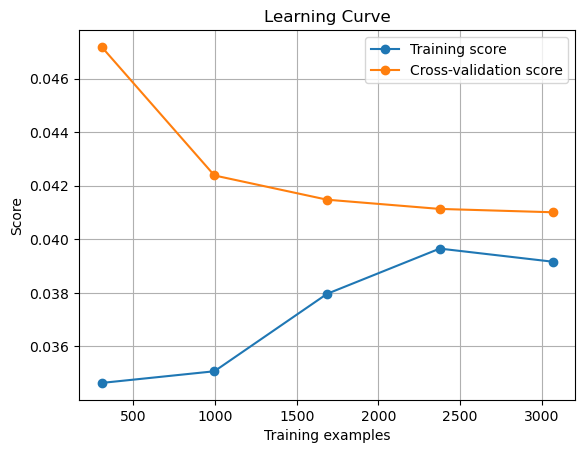

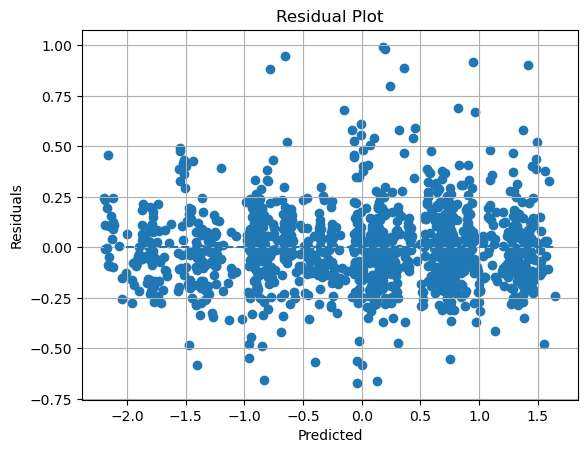

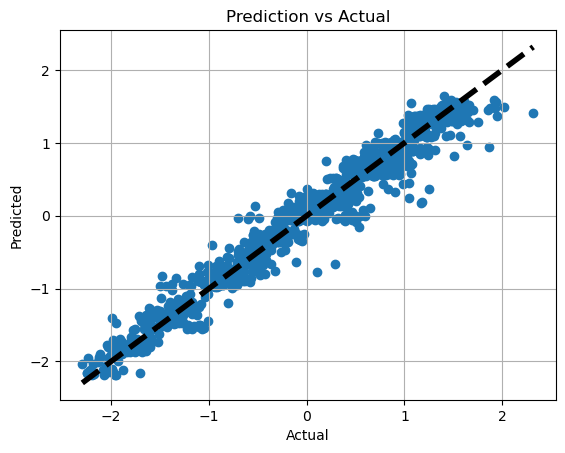

In [16]:
# Define the function to run the Linear Regression model
def run_linear_regression(df_pca_combined, target_column='Weekly_Sales', results_filename='linear_regression_results.csv'):
    df_linreg = df_pca_combined.copy()  # Create a copy of the dataframe
    X_train, X_val, X_test, y_train, y_val, y_test = prepare_data(df_linreg, target_column)
    model = LinearRegression()
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time
    
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)

    lr_train_metrics = evaluate_model(y_train, y_train_pred, X_train, 'Linear Regression (Training)')
    lr_val_metrics = evaluate_model(y_val, y_val_pred, X_val, 'Linear Regression (Validation)')
    lr_test_metrics = evaluate_model(y_test, y_test_pred, X_test, 'Linear Regression (Test)')

    results = [
        {**lr_train_metrics, 'Training Time': training_time},
        lr_val_metrics,
        lr_test_metrics
    ]

    save_results_to_csv(results, results_filename)
    
    for result in results:
        print(result)

    plot_learning_curve(model, X_train, y_train)
    # Linear regression doesn't have n_estimators parameter; skipping validation curve plot
    plot_residuals(y_test, y_test_pred)
    # Linear regression doesn't have feature importances; skipping plot
    plot_prediction_vs_actual(y_test, y_test_pred)

run_linear_regression(df_pca_combined)

### Lasso Regression

{'Dataset': 'Lasso Regression (Training)', 'MSE': 0.9923975868464695, 'RMSE': 0.9961915412441874, 'MAE': 0.8408370949319544, 'MAPE': 101.6083490804616, 'R²': 0.0, 'Adjusted R²': -0.013484928609201585, 'Training Time': 0.5763850212097168}
{'Dataset': 'Lasso Regression (Validation)', 'MSE': 1.0073392082287553, 'RMSE': 1.0036628957118796, 'MAE': 0.8481676857398381, 'MAPE': 102.50783345479691, 'R²': -0.00022396626044596246, 'Adjusted R²': -0.0418319779074956, 'Training Time': None}
{'Dataset': 'Lasso Regression (Test)', 'MSE': 1.0241705229567117, 'RMSE': 1.0120131041427831, 'MAE': 0.8627941256605102, 'MAPE': 101.95919141597128, 'R²': -2.4832174803979257e-05, 'Adjusted R²': -0.04159065649502813, 'Training Time': None}


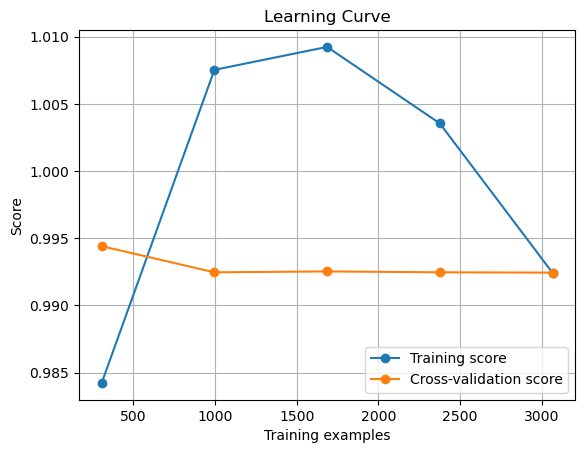

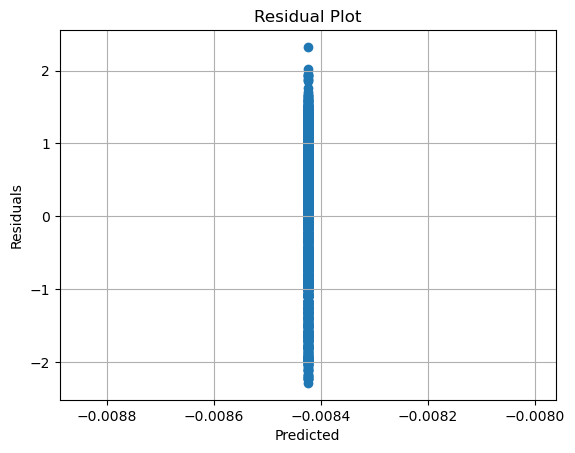

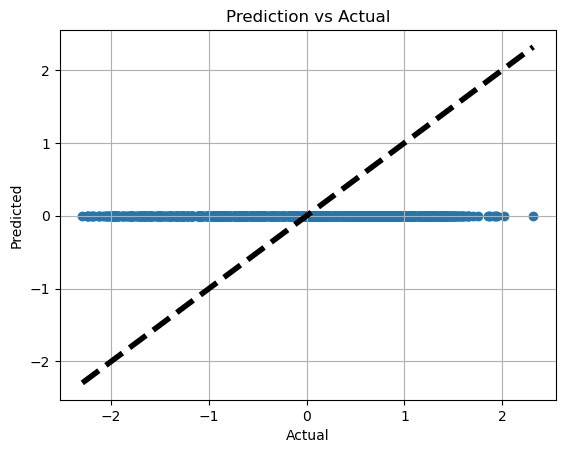

In [17]:
# Define the function to run the Lasso Regression model with Random Search
def run_lasso_regression(df_pca_combined, target_column='Weekly_Sales', results_filename='lasso_regression_results.csv'):
    df_lassoreg = df_pca_combined.copy()  # Create a copy of the dataframe
    X_train, X_val, X_test, y_train, y_val, y_test = prepare_data(df_lassoreg, target_column)
    
    # Define the parameter distribution for alpha
    param_dist = {'alpha': uniform(0.0001, 10)}  # Uniform distribution over [0.0001, 10]

    # Set up the RandomizedSearchCV with Lasso regression
    random_search = RandomizedSearchCV(Lasso(), param_dist, n_iter=50, cv=5, scoring='neg_mean_squared_error', random_state=42)
    
    start_time = time.time()
    random_search.fit(X_train, y_train)
    training_time = time.time() - start_time
    
    # Best model from random search
    best_model = random_search.best_estimator_
    
    y_train_pred = best_model.predict(X_train)
    y_val_pred = best_model.predict(X_val)
    y_test_pred = best_model.predict(X_test)

    lasso_train_metrics = evaluate_model(y_train, y_train_pred, X_train, 'Lasso Regression (Training)')
    lasso_val_metrics = evaluate_model(y_val, y_val_pred, X_val, 'Lasso Regression (Validation)')
    lasso_test_metrics = evaluate_model(y_test, y_test_pred, X_test, 'Lasso Regression (Test)')

    results = [
        {**lasso_train_metrics, 'Training Time': training_time},
        lasso_val_metrics,
        lasso_test_metrics
    ]

    save_results_to_csv(results, results_filename)
    
    for result in results:
        print(result)

    plot_learning_curve(best_model, X_train, y_train)
    plot_residuals(y_test, y_test_pred)
    plot_prediction_vs_actual(y_test, y_test_pred)

run_lasso_regression(df_pca_combined)

### Ridge Regression

Cross-Validation Results (5-fold):
MSE: 0.04097799584428696 ± 0.0055396947858548035
RMSE: 0.2019821954288116 ± 0.013460630521796912
MAE: 0.1453893178205718 ± 0.0070330333914460285
MAPE: 0.6700027701414087 ± 0.16418062833501162
R²: 0.958775778166619 ± 0.00481721075484092
{'Dataset': 'Ridge Regression (Training)', 'MSE': 0.03935044476224412, 'RMSE': 0.19836946529706662, 'MAE': 0.14241261706401914, 'MAPE': 64.69429346594701, 'R²': 0.9603481051507918, 'Adjusted R²': 0.9598134021795307, 'Training Time': 0.5729060173034668}
{'Dataset': 'Ridge Regression (Validation)', 'MSE': 0.03927151327647541, 'RMSE': 0.19817041473558916, 'MAE': 0.13975229349398935, 'MAPE': 55.975274092701945, 'R²': 0.9610058772163608, 'Adjusted R²': 0.959383772598118, 'Training Time': None}
{'Dataset': 'Ridge Regression (Test)', 'MSE': 0.03819709087822367, 'RMSE': 0.19544076053429507, 'MAE': 0.1423260100446113, 'MAPE': 71.07635069236349, 'R²': 0.96270343801266, 'Adjusted R²': 0.9611532141647755, 'Training Time': None}


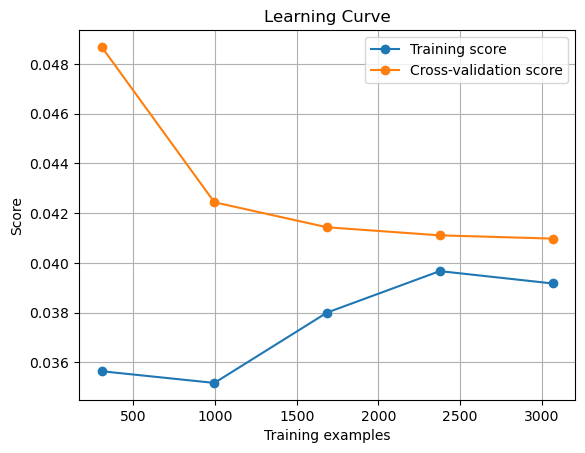

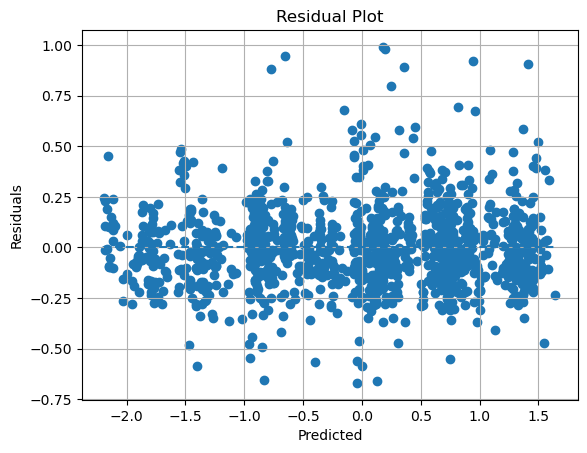

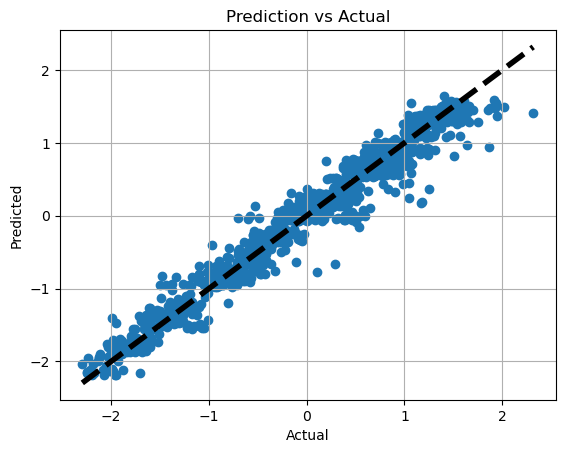

In [18]:
# Define the function to run the Ridge Regression model with Random Search
def run_ridge_regression(df_pca_combined, target_column='Weekly_Sales', results_filename='ridge_regression_results.csv'):
    df_ridgereg = df_pca_combined.copy()  # Create a copy of the dataframe
    X_train, X_val, X_test, y_train, y_val, y_test = prepare_data(df_ridgereg, target_column)
    
    # Define the parameter distribution for alpha
    param_dist = {'alpha': uniform(0.0001, 10)}  # Uniform distribution over [0.0001, 10]

    # Set up the RandomizedSearchCV with Ridge regression
    random_search = RandomizedSearchCV(Ridge(), param_dist, n_iter=50, cv=5, scoring='neg_mean_squared_error', random_state=42)
    
    start_time = time.time()
    random_search.fit(X_train, y_train)
    training_time = time.time() - start_time
    
    # Best model from random search
    best_model = random_search.best_estimator_
    
    # Perform k-fold cross-validation
    k = 5  # Define the number of folds
    cv_scores = cross_val_score(best_model, X_train, y_train, cv=k, scoring='neg_mean_squared_error')

    # Convert the scores from negative MSE to positive MSE
    cv_mse_scores = -cv_scores
    cv_rmse_scores = np.sqrt(cv_mse_scores)
    cv_mae_scores = cross_val_score(best_model, X_train, y_train, cv=k, scoring='neg_mean_absolute_error')
    cv_mape_scores = cross_val_score(best_model, X_train, y_train, cv=k, scoring='neg_mean_absolute_percentage_error')
    cv_r2_scores = cross_val_score(best_model, X_train, y_train, cv=k, scoring='r2')

    # Print the cross-validation results
    print(f'Cross-Validation Results ({k}-fold):')
    print(f'MSE: {cv_mse_scores.mean()} ± {cv_mse_scores.std()}')
    print(f'RMSE: {cv_rmse_scores.mean()} ± {cv_rmse_scores.std()}')
    print(f'MAE: {-cv_mae_scores.mean()} ± {cv_mae_scores.std()}')
    print(f'MAPE: {-cv_mape_scores.mean()} ± {cv_mape_scores.std()}')
    print(f'R²: {cv_r2_scores.mean()} ± {cv_r2_scores.std()}')

    y_train_pred = best_model.predict(X_train)
    y_val_pred = best_model.predict(X_val)
    y_test_pred = best_model.predict(X_test)

    ridge_train_metrics = evaluate_model(y_train, y_train_pred, X_train, 'Ridge Regression (Training)')
    ridge_val_metrics = evaluate_model(y_val, y_val_pred, X_val, 'Ridge Regression (Validation)')
    ridge_test_metrics = evaluate_model(y_test, y_test_pred, X_test, 'Ridge Regression (Test)')

    results = [
        {**ridge_train_metrics, 'Training Time': training_time},
        ridge_val_metrics,
        ridge_test_metrics
    ]

    save_results_to_csv(results, results_filename)
    
    for result in results:
        print(result)

    plot_learning_curve(best_model, X_train, y_train)
    plot_residuals(y_test, y_test_pred)
    plot_prediction_vs_actual(y_test, y_test_pred)

run_ridge_regression(df_pca_combined)

# Random Forest

{'Dataset': 'Random Forest (Training)', 'MSE': 0.013800839657024626, 'RMSE': 0.11747697500797603, 'MAE': 0.07507332639520395, 'MAPE': 42.90741028303253, 'R²': 0.9860934369047799, 'Adjusted R²': 0.9859059078942415, 'Training Time': 197.81586813926697}
{'Dataset': 'Random Forest (Validation)', 'MSE': 0.026876357081436934, 'RMSE': 0.16394010211487894, 'MAE': 0.10671675538376538, 'MAPE': 54.01570152712905, 'R²': 0.9733134814380002, 'Adjusted R²': 0.9722033570932515, 'Training Time': None}
{'Dataset': 'Random Forest (Test)', 'MSE': 0.025059292953892236, 'RMSE': 0.15830127274880715, 'MAE': 0.10799436917452654, 'MAPE': 77.12569416697113, 'R²': 0.975531501181767, 'Adjusted R²': 0.9745144731135275, 'Training Time': None}
Cross-Validation Results (5-fold):
MSE: 0.027416583339247118 ± 0.004057118887458285
RMSE: 0.16515987772619417 ± 0.011781261762464643
MAE: -0.11064351976437628 ± 0.006030459783449093
MAPE: 58.209318020039916 ± 9.941307219919938
R²: 0.9724171459689913 ± 0.0036269646700598456


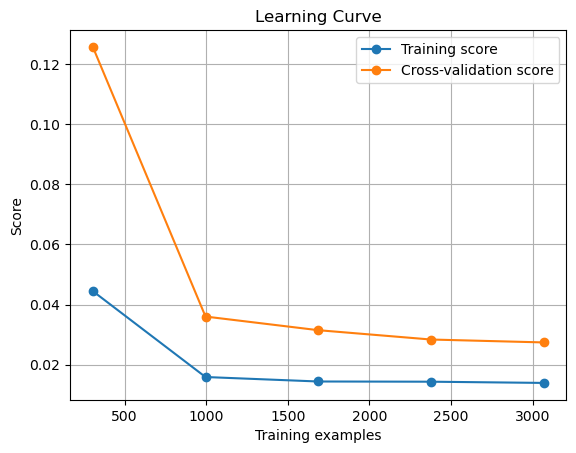

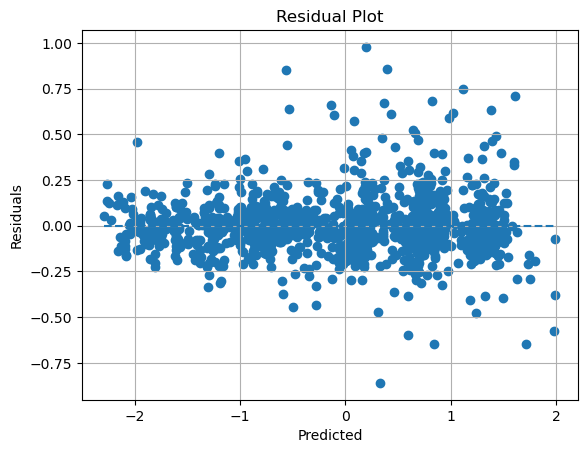

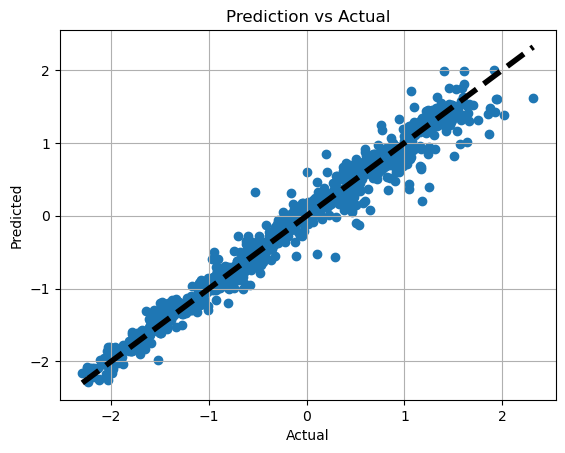

In [19]:
# Define the function to run the Random Forest model with Randomized Search
def run_random_forest(df_pca_combined, target_column='Weekly_Sales', results_filename='random_forest_results.csv'):
    df_randforest = df_pca_combined.copy()  # Create a copy of the dataframe
    X_train, X_val, X_test, y_train, y_val, y_test = prepare_data(df_randforest, target_column)
    
    # Define the parameter distribution for Randomized Search
    param_dist = {
        'n_estimators': randint(100, 500),
        'max_depth': randint(1, 50),
        'min_samples_split': randint(2, 10),
        'min_samples_leaf': randint(1, 10)
    }

    # Set up the RandomizedSearchCV with Random Forest
    random_search = RandomizedSearchCV(
        RandomForestRegressor(random_state=42),
        param_dist,
        n_iter=50,
        cv=5,
        scoring='neg_mean_squared_error',
        random_state=42,
        n_jobs=-1
    )
    
    start_time = time.time()
    random_search.fit(X_train, y_train)
    training_time = time.time() - start_time
    
    # Best model from Randomized Search
    best_model = random_search.best_estimator_
    
    y_train_pred = best_model.predict(X_train)
    y_val_pred = best_model.predict(X_val)
    y_test_pred = best_model.predict(X_test)

    rf_train_metrics = evaluate_model(y_train, y_train_pred, X_train, 'Random Forest (Training)')
    rf_val_metrics = evaluate_model(y_val, y_val_pred, X_val, 'Random Forest (Validation)')
    rf_test_metrics = evaluate_model(y_test, y_test_pred, X_test, 'Random Forest (Test)')

    results = [
        {**rf_train_metrics, 'Training Time': training_time},
        rf_val_metrics,
        rf_test_metrics
    ]

    save_results_to_csv(results, results_filename)
    
    for result in results:
        print(result)

    # Perform 5-fold cross-validation
    cv_results = cross_val_score(best_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    cv_mse = -cv_results
    cv_rmse = np.sqrt(cv_mse)
    cv_mae = cross_val_score(best_model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
    cv_mape = cross_val_score(best_model, X_train, y_train, cv=5, scoring=make_scorer(mean_absolute_percentage_error))
    cv_r2 = cross_val_score(best_model, X_train, y_train, cv=5, scoring='r2')
    
    print("Cross-Validation Results (5-fold):")
    print(f"MSE: {cv_mse.mean()} ± {cv_mse.std()}")
    print(f"RMSE: {cv_rmse.mean()} ± {cv_rmse.std()}")
    print(f"MAE: {cv_mae.mean()} ± {cv_mae.std()}")
    print(f"MAPE: {cv_mape.mean()} ± {cv_mape.std()}")
    print(f"R²: {cv_r2.mean()} ± {cv_r2.std()}")

    plot_learning_curve(best_model, X_train, y_train)
    plot_residuals(y_test, y_test_pred)
    plot_prediction_vs_actual(y_test, y_test_pred)

run_random_forest(df_pca_combined)

# Light GBM

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004539 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1125
[LightGBM] [Info] Number of data points in the train set: 3067, number of used features: 51
[LightGBM] [Info] Start training from score -0.007712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

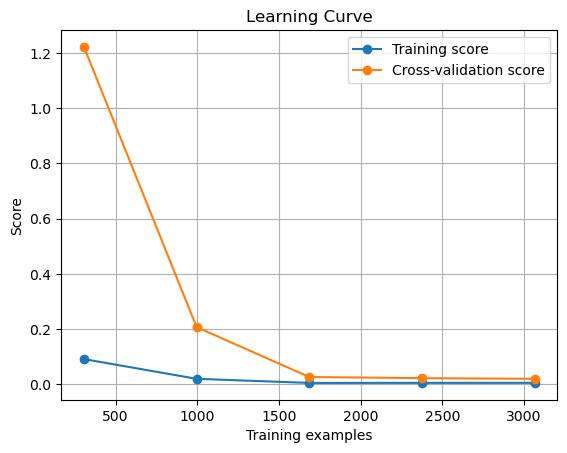

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000705 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1125
[LightGBM] [Info] Number of data points in the train set: 3067, number of used features: 51
[LightGBM] [Info] Start training from

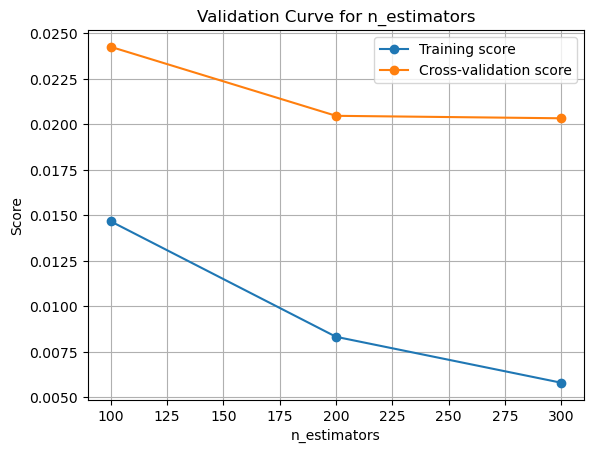

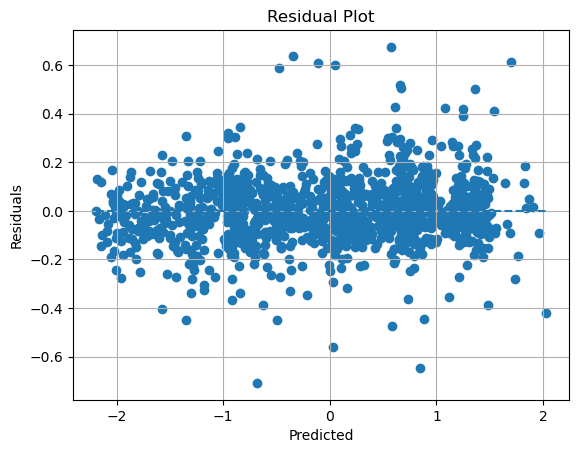

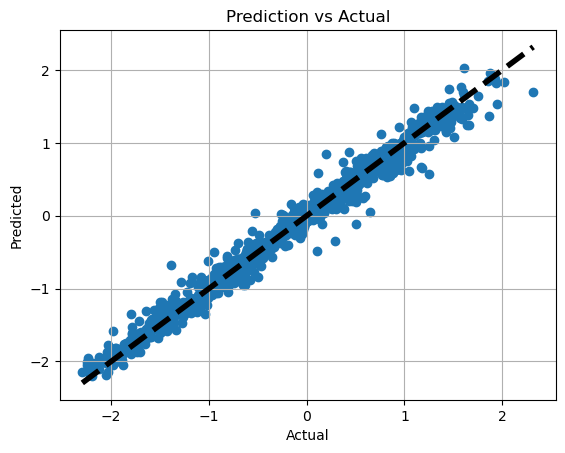

In [20]:
# Define function to run the LightGBM model with hyperparameter tuning and cross-validation
def run_lightgbm(df_pca_combined, target_column='Weekly_Sales', results_filename='lightgbm_results.csv'):
    df_lightgbm = df_pca_combined.copy()  # Create a copy of the dataframe
    X_train, X_val, X_test, y_train, y_val, y_test = prepare_data(df_lightgbm, target_column)
    
    # Define the parameter distribution for hyperparameter tuning
    param_dist = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1],
        'num_leaves': [15, 31, 50],
        'max_depth': [-1, 5, 10],
        'min_child_samples': [20, 30, 40],
        'min_child_weight': [0.001, 0.01, 0.1],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0]
    }
    
    model = LGBMRegressor(random_state=42)
    
    # RandomizedSearchCV for hyperparameter tuning
    random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=50, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1, random_state=42)
    
    start_time = time.time()
    random_search.fit(X_train, y_train)
    training_time = time.time() - start_time
    
    best_model = random_search.best_estimator_
    
    # Evaluate with cross-validation
    cv = KFold(n_splits=5, random_state=42, shuffle=True)
    cv_scores = cross_val_score(best_model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
    cv_mse = -np.mean(cv_scores)
    cv_rmse = np.sqrt(cv_mse)
    cv_mae = -np.mean(cross_val_score(best_model, X_train, y_train, cv=cv, scoring='neg_mean_absolute_error'))
    cv_mape = -np.mean(cross_val_score(best_model, X_train, y_train, cv=cv, scoring='neg_mean_absolute_percentage_error'))
    cv_r2 = np.mean(cross_val_score(best_model, X_train, y_train, cv=cv, scoring='r2'))

    y_train_pred = best_model.predict(X_train)
    y_val_pred = best_model.predict(X_val)
    y_test_pred = best_model.predict(X_test)

    lgbm_train_metrics = evaluate_model(y_train, y_train_pred, X_train, 'LightGBM (Training)')
    lgbm_val_metrics = evaluate_model(y_val, y_val_pred, X_val, 'LightGBM (Validation)')
    lgbm_test_metrics = evaluate_model(y_test, y_test_pred, X_test, 'LightGBM (Test)')
    lgbm_cv_metrics = {
        'Dataset': 'LightGBM (CV)',
        'MSE': cv_mse,
        'RMSE': cv_rmse,
        'MAE': cv_mae,
        'MAPE': cv_mape,
        'R²': cv_r2,
        'Adjusted R²': None,
        'Training Time': None
    }

    results = [
        {**lgbm_train_metrics, 'Training Time': training_time},
        lgbm_val_metrics,
        lgbm_test_metrics,
        lgbm_cv_metrics
    ]

    save_results_to_csv(results, results_filename)
    
    for result in results:
        print(result)

    plot_learning_curve(best_model, X_train, y_train)
    plot_validation_curve(best_model, X_train, y_train, param_name='n_estimators', param_range=[100, 200, 300])
    plot_residuals(y_test, y_test_pred)
    plot_prediction_vs_actual(y_test, y_test_pred)

# Suppress specific LightGBM warning
warnings.filterwarnings("ignore", message="No further splits with positive gain, best gain: -inf")

run_lightgbm(df_pca_combined)

### XGBoost

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

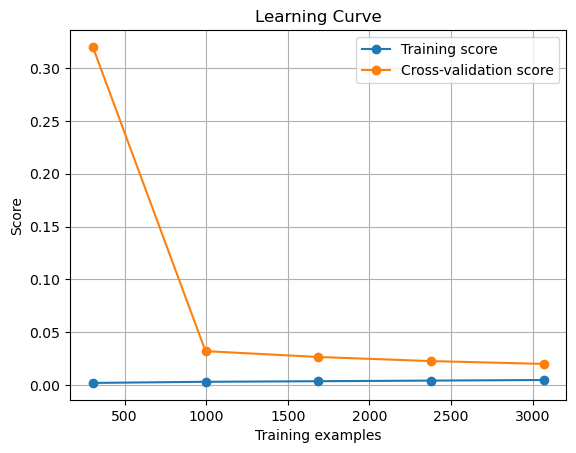

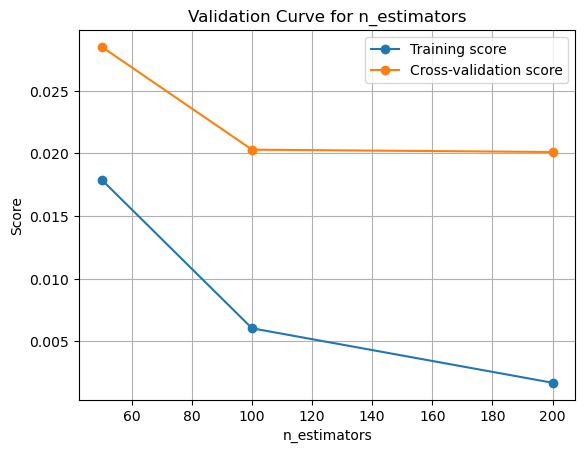

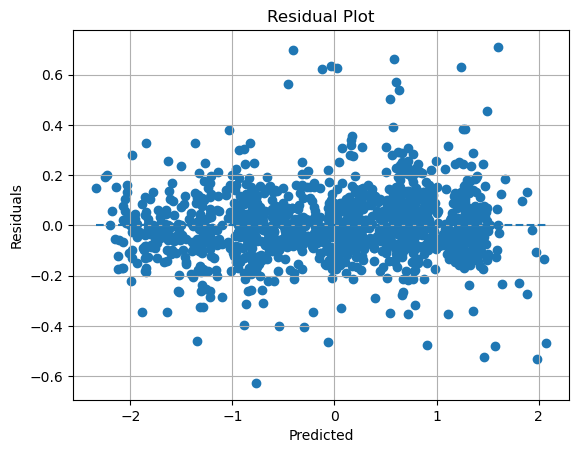

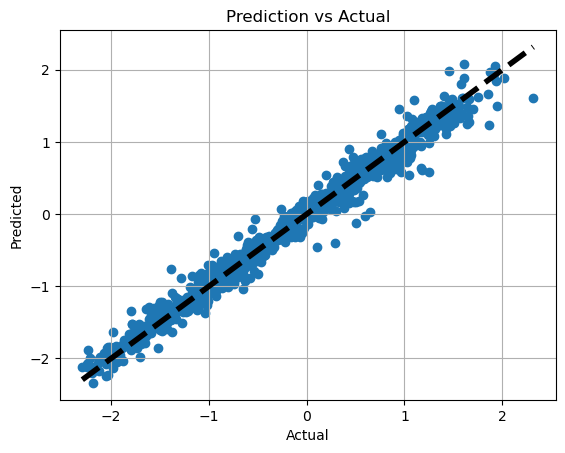

In [21]:
def run_xgboost(df_pca_combined, target_column='Weekly_Sales', results_filename='xgboost_results.csv'):
    df_xgboost = df_pca_combined.copy()  # Create a copy of the dataframe
    X_train, X_val, X_test, y_train, y_val, y_test = prepare_data(df_xgboost, target_column)

    # Define the model
    model = XGBRegressor(random_state=42)

    # Define hyperparameter distribution
    param_dist = {
        'n_estimators': randint(50, 200),
        'learning_rate': uniform(0.01, 0.19),
        'max_depth': randint(3, 10),
        'min_child_weight': randint(1, 6),
        'subsample': uniform(0.6, 0.4),
        'colsample_bytree': uniform(0.6, 0.4)
    }

    # Random Search with Cross-Validation
    random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=50, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42, verbose=2)
    start_time = time.time()
    random_search.fit(X_train, y_train)
    training_time = time.time() - start_time

    # Best model from random search
    best_model = random_search.best_estimator_

    # Predictions
    y_train_pred = best_model.predict(X_train)
    y_val_pred = best_model.predict(X_val)
    y_test_pred = best_model.predict(X_test)

    # Evaluate metrics
    xgb_train_metrics = evaluate_model(y_train, y_train_pred, X_train, 'XGBoost (Training)')
    xgb_train_metrics['Training Time'] = training_time  # Update training time
    xgb_val_metrics = evaluate_model(y_val, y_val_pred, X_val, 'XGBoost (Validation)')
    xgb_test_metrics = evaluate_model(y_test, y_test_pred, X_test, 'XGBoost (Test)')

    results = [
        xgb_train_metrics,
        xgb_val_metrics,
        xgb_test_metrics
    ]

    save_results_to_csv(results, results_filename)
    
    for result in results:
        print(result)

    plot_learning_curve(best_model, X_train, y_train)
    plot_validation_curve(best_model, X_train, y_train, param_name='n_estimators', param_range=[50, 100, 200])
    plot_residuals(y_test, y_test_pred)
    plot_prediction_vs_actual(y_test, y_test_pred)

run_xgboost(df_pca_combined)

# CatBoost

Fitting 5 folds for each of 50 candidates, totalling 250 fits
{'Dataset': 'CatBoost (Training)', 'MSE': 0.010298863166639275, 'RMSE': 0.10148331472039764, 'MAE': 0.07598893574110617, 'MAPE': 37.49784776208253, 'R²': 0.9896222408204701, 'Adjusted R²': 0.9894822974788107, 'Training Time': 34.838927268981934}
{'Dataset': 'CatBoost (Validation)', 'MSE': 0.018627920485821896, 'RMSE': 0.13648414005232218, 'MAE': 0.09550928672331391, 'MAPE': 45.21498832693494, 'R²': 0.9815036560085112, 'Adjusted R²': 0.9807342322372502, 'Training Time': None}
{'Dataset': 'CatBoost (Test)', 'MSE': 0.018287822768094326, 'RMSE': 0.13523247675057323, 'MAE': 0.09685706467648265, 'MAPE': 43.59383463402641, 'R²': 0.9821433282011388, 'Adjusted R²': 0.9814011193488634, 'Training Time': None}
{'Dataset': 'CatBoost (CV)', 'MSE': 0.020581563136738548, 'RMSE': 0.14346275871019123, 'MAE': None, 'MAPE': None, 'R²': None, 'Adjusted R²': None, 'Training Time': None}


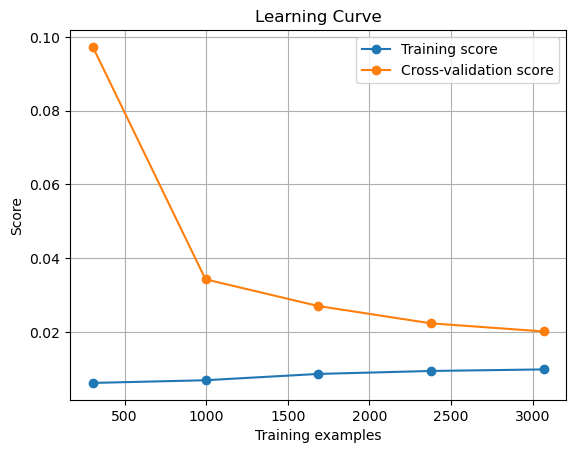

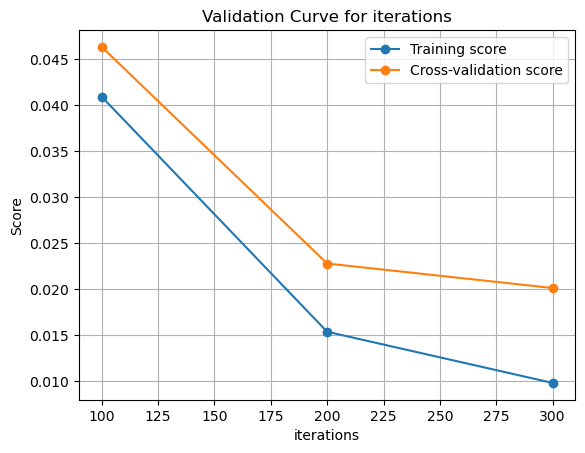

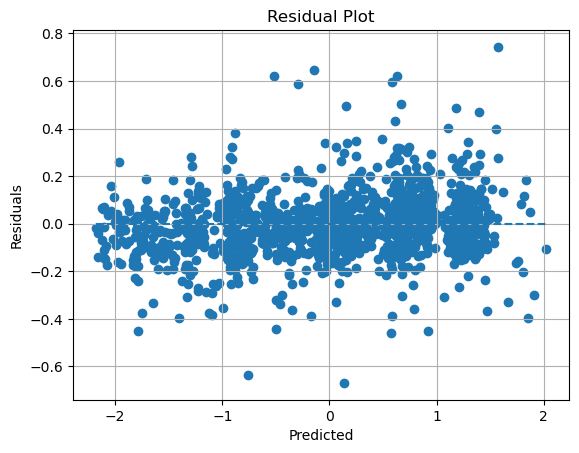

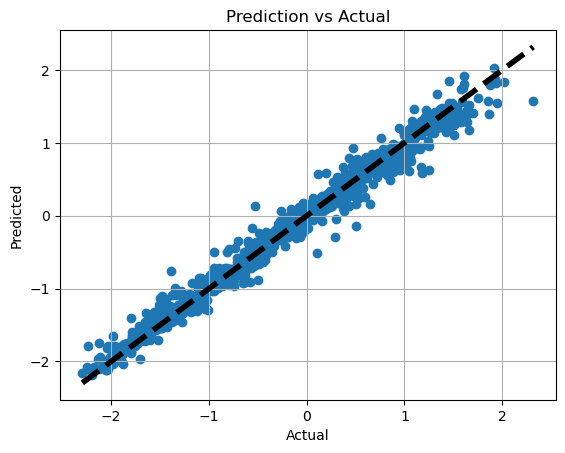

In [22]:
# Define function to run the CatBoost model with hyperparameter tuning and cross-validation
def run_catboost(df, target_column='Weekly_Sales', results_filename='catboost_results.csv'):
    df_catboost = df.copy()  # Create a copy of the dataframe
    X_train, X_val, X_test, y_train, y_val, y_test = prepare_data(df_catboost, target_column)
    
    # Define the parameter distribution for hyperparameter tuning
    param_dist = {
        'iterations': [100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1],
        'depth': [4, 6, 8, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9]
    }
    
    model = CatBoostRegressor(random_state=42, silent=True)
    
    # RandomizedSearchCV for hyperparameter tuning
    random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=50, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1, random_state=42)
    
    start_time = time.time()
    random_search.fit(X_train, y_train)
    training_time = time.time() - start_time
    
    best_model = random_search.best_estimator_
    
    # Evaluate with cross-validation
    cv = KFold(n_splits=5, random_state=42, shuffle=True)
    cv_scores = cross_val_score(best_model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
    cv_mse = -np.mean(cv_scores)
    
    y_train_pred = best_model.predict(X_train)
    y_val_pred = best_model.predict(X_val)
    y_test_pred = best_model.predict(X_test)

    catboost_train_metrics = evaluate_model(y_train, y_train_pred, X_train, 'CatBoost (Training)')
    catboost_val_metrics = evaluate_model(y_val, y_val_pred, X_val, 'CatBoost (Validation)')
    catboost_test_metrics = evaluate_model(y_test, y_test_pred, X_test, 'CatBoost (Test)')
    catboost_cv_metrics = {'Dataset': 'CatBoost (CV)', 'MSE': cv_mse, 'RMSE': np.sqrt(cv_mse), 'MAE': None, 'MAPE': None, 'R²': None, 'Adjusted R²': None, 'Training Time': None}

    results = [
        {**catboost_train_metrics, 'Training Time': training_time},
        catboost_val_metrics,
        catboost_test_metrics,
        catboost_cv_metrics
    ]

    save_results_to_csv(results, results_filename)
    
    for result in results:
        print(result)

    plot_learning_curve(best_model, X_train, y_train)
    plot_validation_curve(best_model, X_train, y_train, param_name='iterations', param_range=[100, 200, 300])
    plot_residuals(y_test, y_test_pred)
    plot_prediction_vs_actual(y_test, y_test_pred)
    
run_catboost(df_pca_combined)

# RNN

Fitting 5 folds for each of 20 candidates, totalling 100 fits
{'Dataset': 'RNN (Training)', 'MSE': 0.03382509127476168, 'RMSE': 0.18391598972020262, 'MAE': 0.14293260722983636, 'MAPE': 79.68087854575656, 'R²': 0.965915786451832, 'Adjusted R²': 0.9659068918240793, 'Training Time': 84.27554202079773}
{'Dataset': 'RNN (Validation)', 'MSE': 0.041517183674937036, 'RMSE': 0.20375765918104044, 'MAE': 0.15586166308590202, 'MAPE': 79.56598876901538, 'R²': 0.9587760688911071, 'Adjusted R²': 0.9587437617350657, 'Training Time': None}
{'Dataset': 'RNN (Test)', 'MSE': 0.03576472348082504, 'RMSE': 0.18911563520984995, 'MAE': 0.14766052930537996, 'MAPE': 98.24438703250861, 'R²': 0.9650784602807769, 'Adjusted R²': 0.9650511137344032, 'Training Time': None}
{'Dataset': 'RNN (CV)', 'MSE': 0.03461411902858121, 'RMSE': 0.186048700690387, 'MAE': None, 'MAPE': None, 'R²': None, 'Adjusted R²': None, 'Training Time': None}


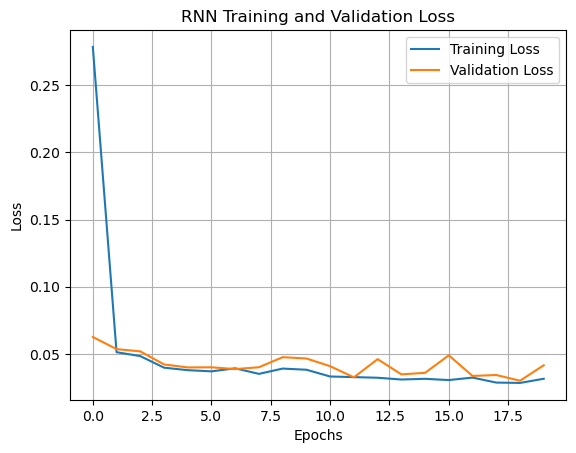

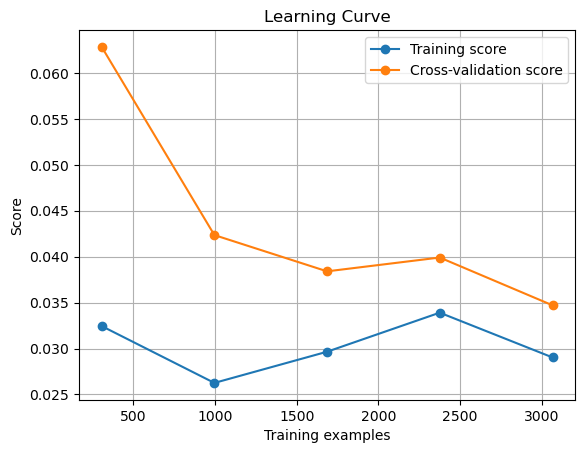

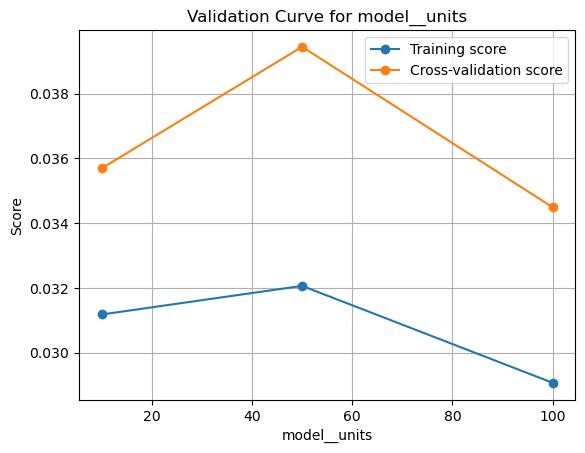

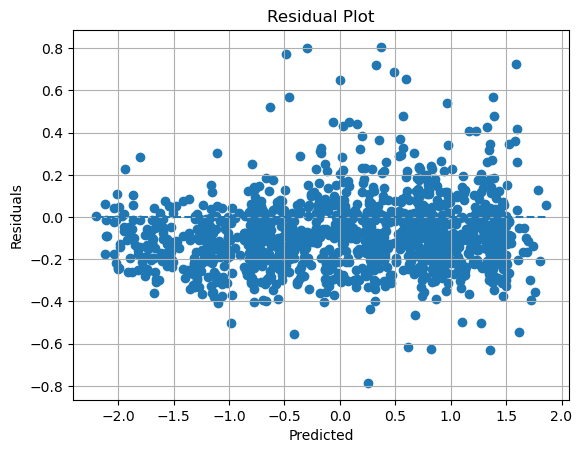

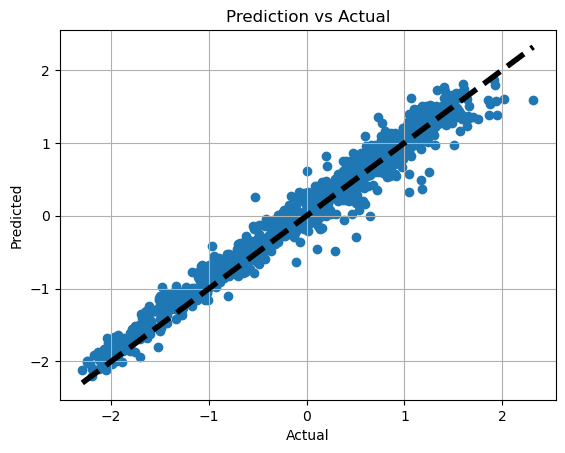

In [23]:
# Define the function to create the RNN model
def create_rnn_model(units=50, learning_rate=0.01, input_shape=(1,)):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(SimpleRNN(units))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return model

# Define the function to run the RNN model with hyperparameter tuning and cross-validation
def run_rnn(df_pca_combined, target_column='Weekly_Sales', results_filename='rnn_results.csv'):
    df_rnn = df_pca_combined.copy()  # Create a copy of the dataframe
    X_train, X_val, X_test, y_train, y_val, y_test = prepare_data(df_rnn, target_column)
    X_train = np.reshape(X_train.values, (X_train.shape[0], 1, X_train.shape[1]))
    X_val = np.reshape(X_val.values, (X_val.shape[0], 1, X_val.shape[1]))
    X_test = np.reshape(X_test.values, (X_test.shape[0], 1, X_test.shape[1]))
    
    input_shape = (1, X_train.shape[2])
    
    # Use History callback to capture training history
    history_callback = History()

    model = KerasRegressor(
        model=create_rnn_model,
        units=50,
        learning_rate=0.01,
        input_shape=input_shape,
        epochs=10,
        batch_size=32,
        verbose=0,
        callbacks=[history_callback]
    )

    # Define the parameter distribution for hyperparameter tuning
    param_dist = {
        'model__units': [10, 50, 100],
        'model__learning_rate': [0.001, 0.01, 0.1],
        'batch_size': [16, 32, 64],
        'epochs': [10, 20, 30]
    }
    
    random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=20, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1, random_state=42)
    
    start_time = time.time()
    random_search.fit(X_train, y_train, validation_data=(X_val, y_val))
    training_time = time.time() - start_time
    
    best_model = random_search.best_estimator_

    # Evaluate with cross-validation
    cv = KFold(n_splits=5, random_state=42, shuffle=True)
    cv_scores = cross_val_score(best_model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
    cv_mse = -np.mean(cv_scores)

    y_train_pred = best_model.predict(X_train).flatten()
    y_val_pred = best_model.predict(X_val).flatten()
    y_test_pred = best_model.predict(X_test).flatten()

    rnn_train_metrics = evaluate_model(y_train, y_train_pred, X_train, 'RNN (Training)')
    rnn_train_metrics['Training Time'] = training_time  # Update training time
    rnn_val_metrics = evaluate_model(y_val, y_val_pred, X_val, 'RNN (Validation)')
    rnn_test_metrics = evaluate_model(y_test, y_test_pred, X_test, 'RNN (Test)')
    rnn_cv_metrics = {'Dataset': 'RNN (CV)', 'MSE': cv_mse, 'RMSE': np.sqrt(cv_mse), 'MAE': None, 'MAPE': None, 'R²': None, 'Adjusted R²': None, 'Training Time': None}

    results = [
        rnn_train_metrics,
        rnn_val_metrics,
        rnn_test_metrics,
        rnn_cv_metrics
    ]

    save_results_to_csv(results, results_filename)
    
    for result in results:
        print(result)

    # Plot training history
    history = best_model.model_.history.history
    plt.figure()
    plt.plot(history['loss'], label='Training Loss')
    if 'val_loss' in history:
        plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('RNN Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

    plot_learning_curve(best_model, X_train, y_train)
    plot_validation_curve(best_model, X_train, y_train, param_name='model__units', param_range=[10, 50, 100])
    plot_residuals(y_test, y_test_pred)
    plot_prediction_vs_actual(y_test, y_test_pred)

run_rnn(df_pca_combined)

# LSTM

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.2154 - val_loss: 0.0903
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1190 - val_loss: 0.0811
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0873 - val_loss: 0.1113
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0964 - val_loss: 0.1303
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0919 - val_loss: 0.1038
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0824 - val_loss: 0.0787
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0766 - val_loss: 0.0772
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0803 - val_loss: 0.0770
Epoch 9/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0758 - val_loss: 0.0887
Epoch 10/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0789 - val_loss: 0.1008
History Keys: dict_keys(['loss', 'val_loss'])
Loss and Val_Loss found in history


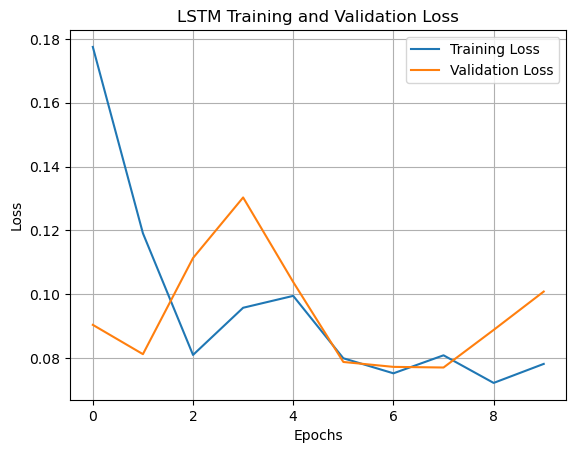

Plotting Training Loss vs Validation Loss completed


In [27]:
# Testing code (ignore)

# Define the LSTM model
def create_lstm_model(units=50, learning_rate=0.01, input_shape=(1, 10)):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(LSTM(units))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return model

# Create and train the model with History callback
model = create_lstm_model()
history_callback = History()
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32, callbacks=[history_callback])

# Plot training history
history = history_callback.history
print("History Keys:", history.keys())  # Print the keys in the history dictionary

if 'loss' in history and 'val_loss' in history:
    print("Loss and Val_Loss found in history")
    plt.figure()
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('LSTM Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

    print("Plotting Training Loss vs Validation Loss completed")
else:
    print("Loss and/or Val_Loss not found in history")

Preparing data...
Data shapes - X_train: (3834, 51), X_val: (1278, 51), X_test: (1279, 51), y_train: (3834,), y_val: (1278,), y_test: (1279,)
Starting RandomizedSearchCV...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters found:  {'model__units': 50, 'model__learning_rate': 0.01, 'epochs': 30, 'batch_size': 32}
Fitting best model with History callback...
Training completed. Evaluating cross-validation...
Evaluating model performance...
Saving results to CSV...
{'Dataset': 'LSTM (Training)', 'MSE': 0.015308650631377005, 'RMSE': 0.12372813193197821, 'MAE': 0.08973404414841854, 'MAPE': 45.82861580649231, 'R²': 0.9845740751143671, 'Adjusted R²': 0.9845700495598563, 'Training Time': 90.0471761226654}
{'Dataset': 'LSTM (Validation)', 'MSE': 0.02695268409628174, 'RMSE': 0.16417272640813924, 'MAE': 0.11096238416808868, 'MAPE': 53.51145598829, 'R²': 0.9732376935515591, 'Adjusted R²': 0.9732167199571637, 'Training Time': None}
{'Dataset': 'LSTM (Test)', 'MSE': 0.0252

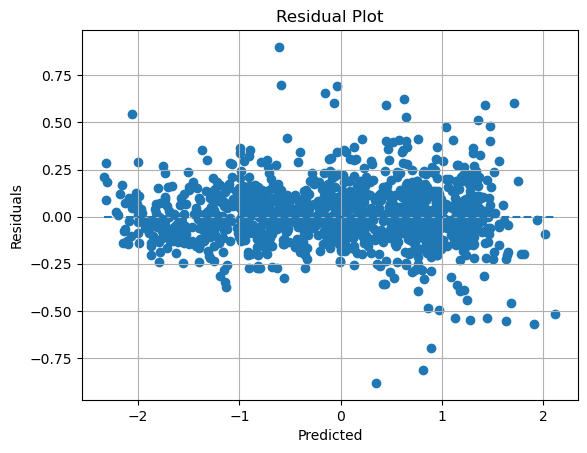

Plotting Prediction vs Actual...


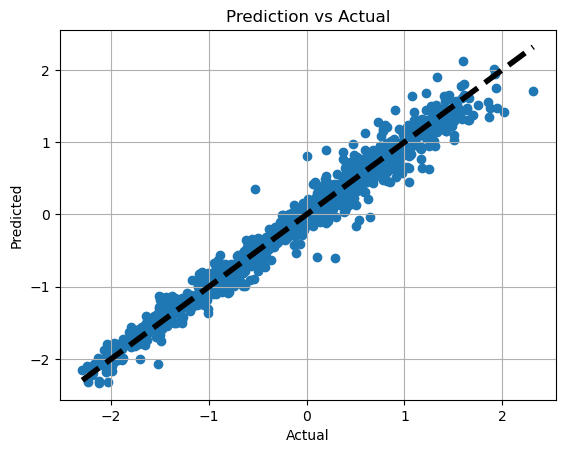

In [25]:
# Define the function to create the LSTM model
def create_lstm_model(units=50, learning_rate=0.01, input_shape=(1,)):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(LSTM(units))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return model

# Define the function to run the LSTM model with hyperparameter tuning and cross-validation
def run_lstm(df_pca_combined, target_column='Weekly_Sales', results_filename='lstm_results.csv'):
    df_lstm = df_pca_combined.copy()  # Create a copy of the dataframe

    # Prepare data function should be defined elsewhere
    print("Preparing data...")
    X_train, X_val, X_test, y_train, y_val, y_test = prepare_data(df_lstm, target_column)
    
    print("Data shapes - X_train: {}, X_val: {}, X_test: {}, y_train: {}, y_val: {}, y_test: {}".format(
        X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape))
    
    X_train = np.reshape(X_train.values, (X_train.shape[0], 1, X_train.shape[1]))
    X_val = np.reshape(X_val.values, (X_val.shape[0], 1, X_val.shape[1]))
    X_test = np.reshape(X_test.values, (X_test.shape[0], 1, X_test.shape[1]))
    
    input_shape = (1, X_train.shape[2])
    
    model = KerasRegressor(
        model=create_lstm_model,
        units=50,
        learning_rate=0.01,
        input_shape=input_shape,
        epochs=10,
        batch_size=32,
        verbose=0,
    )

    # Define the parameter distribution for hyperparameter tuning
    param_dist = {
        'model__units': [10, 50, 100],
        'model__learning_rate': [0.001, 0.01, 0.1],
        'batch_size': [16, 32, 64],
        'epochs': [10, 20, 30]
    }

    print("Starting RandomizedSearchCV...")
    random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=20, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1, random_state=42)
    
    start_time = time.time()
    random_search.fit(X_train, y_train)
    training_time = time.time() - start_time
    
    best_params = random_search.best_params_
    print("Best parameters found: ", best_params)

    # Refit the best model to capture the training history
    best_model = KerasRegressor(
        model=create_lstm_model,
        units=best_params['model__units'],
        learning_rate=best_params['model__learning_rate'],
        input_shape=input_shape,
        epochs=best_params['epochs'],
        batch_size=best_params['batch_size'],
        verbose=0,
    )
    history_callback = History()
    print("Fitting best model with History callback...")
    best_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0, callbacks=[history_callback])

    print("Training completed. Evaluating cross-validation...")
    # Evaluate with cross-validation
    cv = KFold(n_splits=5, random_state=42, shuffle=True)
    cv_scores = cross_val_score(random_search.best_estimator_, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
    cv_mse = -np.mean(cv_scores)

    y_train_pred = best_model.predict(X_train).flatten()
    y_val_pred = best_model.predict(X_val).flatten()
    y_test_pred = best_model.predict(X_test).flatten()

    print("Evaluating model performance...")
    lstm_train_metrics = evaluate_model(y_train, y_train_pred, X_train, 'LSTM (Training)')
    lstm_train_metrics['Training Time'] = training_time  # Update training time
    lstm_val_metrics = evaluate_model(y_val, y_val_pred, X_val, 'LSTM (Validation)')
    lstm_test_metrics = evaluate_model(y_test, y_test_pred, X_test, 'LSTM (Test)')
    lstm_cv_metrics = {'Dataset': 'LSTM (CV)', 'MSE': cv_mse, 'RMSE': np.sqrt(cv_mse), 'MAE': None, 'MAPE': None, 'R²': None, 'Adjusted R²': None, 'Training Time': None}

    results = [
        lstm_train_metrics,
        lstm_val_metrics,
        lstm_test_metrics,
        lstm_cv_metrics
    ]

    print("Saving results to CSV...")
    save_results_to_csv(results, results_filename)
    
    for result in results:
        print(result)

    # Plot training history
    history = history_callback.history
    
    print("History Keys:", history.keys())  # Print the keys in the history dictionary
    
    if 'loss' in history and 'val_loss' in history:
        print("Loss and Val_Loss found in history")
        plt.figure()
        plt.plot(history['loss'], label='Training Loss')
        plt.plot(history['val_loss'], label='Validation Loss')
        plt.title('LSTM Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid()
        plt.show()
        
        print("Plotting Training Loss vs Validation Loss completed")

        # Plot cross-validation loss vs training loss
        plt.figure()
        plt.plot(history['loss'], label='Training Loss')
        plt.plot(history['val_loss'], label='Validation Loss')
        plt.plot([cv_mse] * len(history['loss']), label='Cross-Validation Loss', linestyle='--')
        plt.title('Training Loss vs Cross-Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid()
        plt.show()
        
        print("Plotting Training Loss vs Cross-Validation Loss completed")
    else:
        print("Loss and/or Val_Loss not found in history")

    # Plot residuals
    print("Plotting Residuals...")
    plot_residuals(y_test, y_test_pred)

    # Plot prediction vs actual
    print("Plotting Prediction vs Actual...")
    plot_prediction_vs_actual(y_test, y_test_pred)

run_lstm(df_pca_combined)

# Inter-Model Comparison

Model Performance Comparison:
                           Dataset       MSE      RMSE       MAE        MAPE  \
0     Linear Regression (Training)  0.039344  0.198354  0.142481   64.808979   
1   Linear Regression (Validation)  0.039219  0.198038  0.139619   56.015551   
2         Linear Regression (Test)  0.038188  0.195417  0.142315   71.071822   
3      Ridge Regression (Training)  0.039350  0.198369  0.142413   64.694293   
4    Ridge Regression (Validation)  0.039272  0.198170  0.139752   55.975274   
5          Ridge Regression (Test)  0.038197  0.195441  0.142326   71.076351   
6      Lasso Regression (Training)  0.992398  0.996192  0.840837  101.608349   
7    Lasso Regression (Validation)  1.007339  1.003663  0.848168  102.507833   
8          Lasso Regression (Test)  1.024171  1.012013  0.862794  101.959191   
9         Random Forest (Training)  0.013801  0.117477  0.075073   42.907410   
10      Random Forest (Validation)  0.026876  0.163940  0.106717   54.015702   
11        

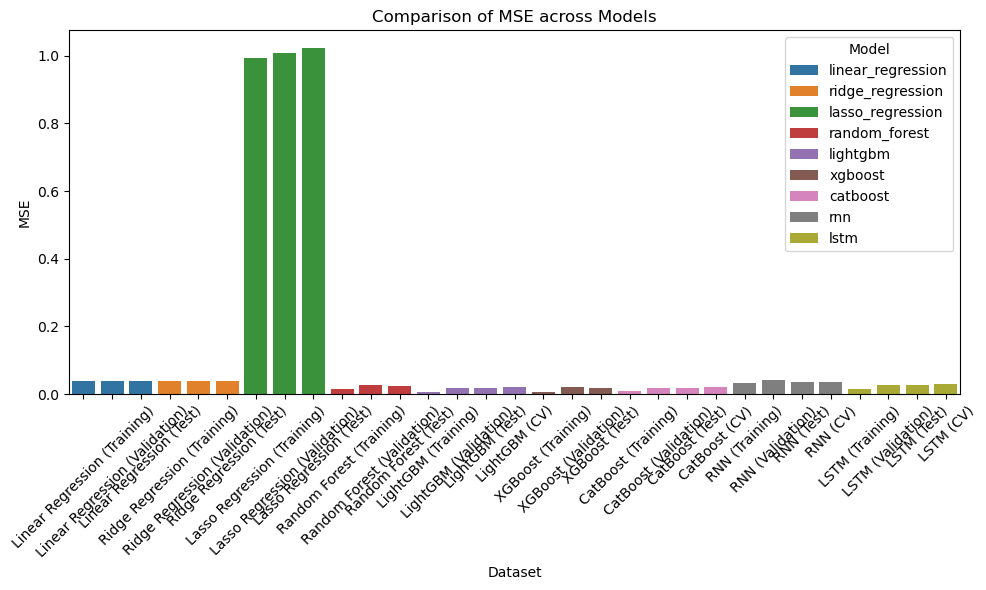

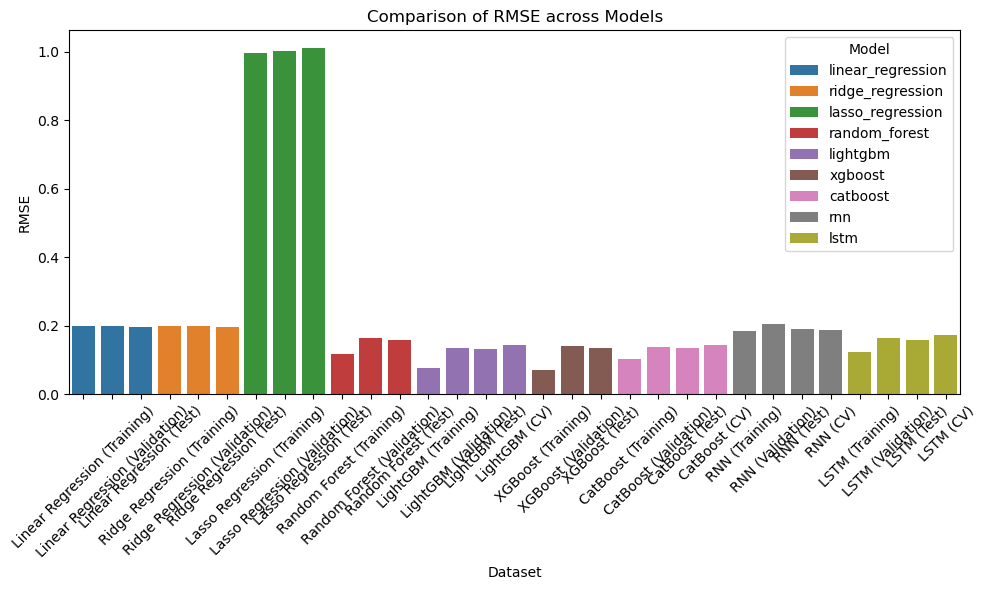

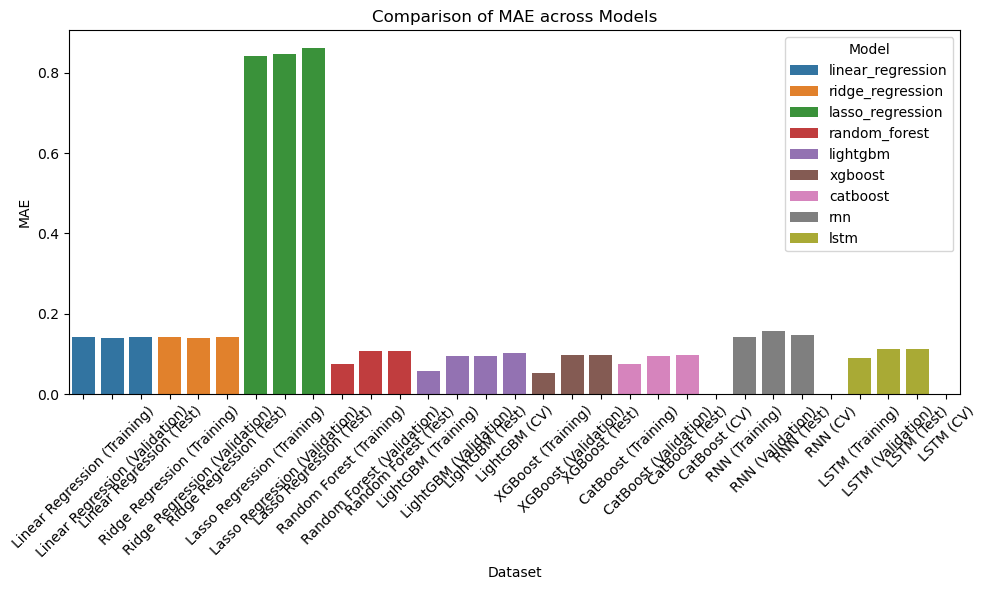

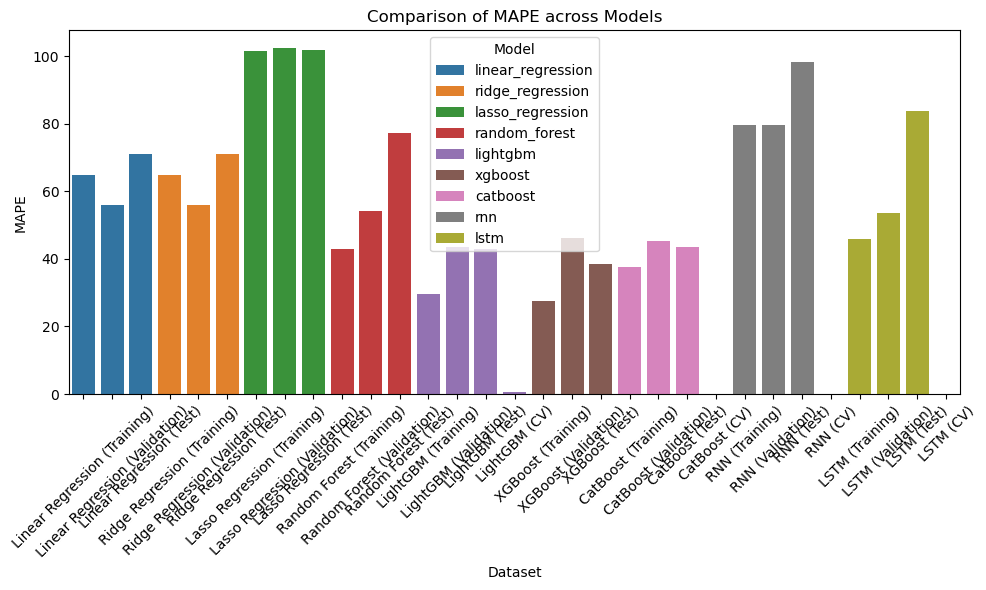

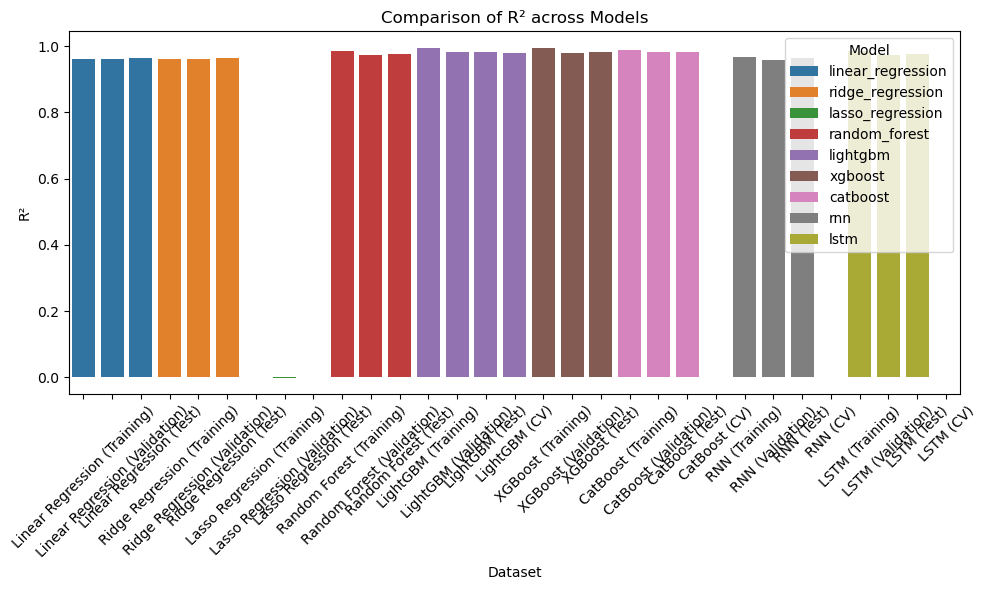

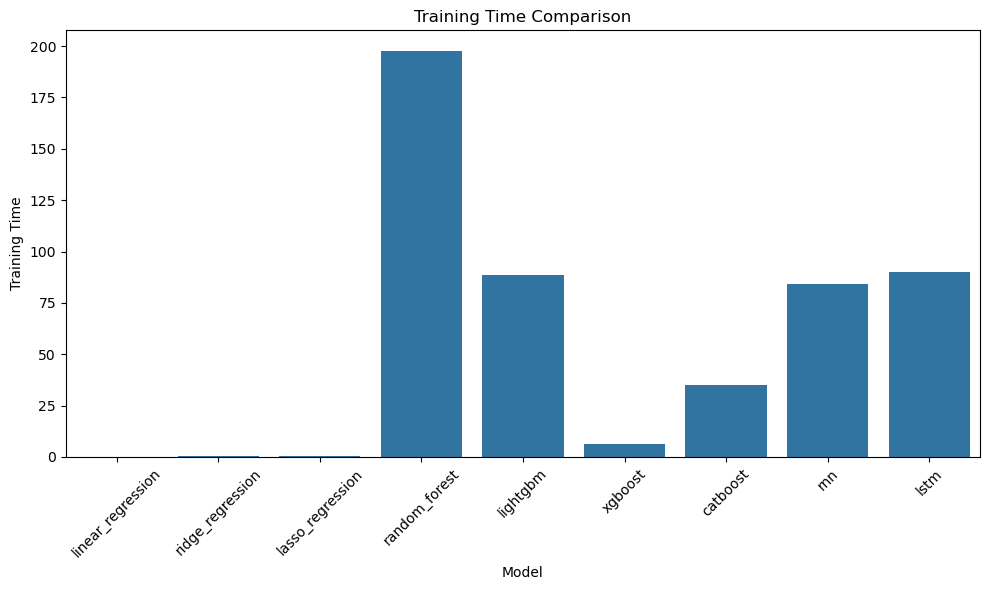

In [28]:
# Function to read results from CSV files
def read_results(files):
    results = []
    for file in files:
        df = pd.read_csv(file)
        model_name = file.split('_results')[0]  # Extract model name from file name
        df['Model'] = model_name
        results.extend(df.to_dict('records'))
    return results

# Function to plot model metrics
def plot_metrics(results):
    df = pd.DataFrame(results)
    metrics = ['MSE', 'RMSE', 'MAE', 'MAPE', 'R²']
    
    for metric in metrics:
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Dataset', y=metric, hue='Model', data=df)
        plt.title(f'Comparison of {metric} across Models')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

# Function to plot training time
def plot_timing(results):
    df = pd.DataFrame(results)
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Model', y='Training Time', data=df)
    plt.title('Training Time Comparison')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Example main function to run the code
def main():
    # List of result files
    result_files = [
        'linear_regression_results.csv',
        'ridge_regression_results.csv',
        'lasso_regression_results.csv',
        'random_forest_results.csv',
        'lightgbm_results.csv',
        'xgboost_results.csv',
        'catboost_results.csv',
        'rnn_results.csv',
        'lstm_results.csv'
    ]
    
    results = read_results(result_files)

    print("Model Performance Comparison:")
    print(pd.DataFrame(results))

    plot_metrics(results)
    plot_timing(results)

if __name__ == "__main__":
    main()

In [30]:
# Function to read results from CSV files
def read_results(files):
    results = []
    for file in files:
        df = pd.read_csv(file)
        model_name = file.split('_results')[0]  # Extract model name from file name
        df['Model'] = model_name
        results.extend(df.to_dict('records'))
    return results

# Function to create tables by model and save them to an HTML file
def create_tables_by_model(results):
    df = pd.DataFrame(results)
    models = df['Model'].unique()
    
    html_output = ""
    
    for model in models:
        model_df = df[df['Model'] == model]
        
        # Print the table for the current model
        print(f"\nModel: {model}\n")
        print(model_df)
        
        # Add the model table to the HTML output
        html_output += f"<h2>Model: {model}</h2>\n"
        html_output += model_df.to_html(index=False)
        html_output += "<br>\n"
    
    # Save the HTML output to a file
    with open("model_performance_comparison.html", "w") as file:
        file.write(html_output)

    print("\nTables have been saved to model_performance_comparison.html")

# Example main function to run the code
def main():
    # List of result files
    result_files = [
        'linear_regression_results.csv',
        'ridge_regression_results.csv',
        'lasso_regression_results.csv',
        'random_forest_results.csv',
        'lightgbm_results.csv',
        'xgboost_results.csv',
        'catboost_results.csv',
        'rnn_results.csv',
        'lstm_results.csv'
    ]
    
    results = read_results(result_files)

    print("Model Performance Comparison:\n")
    
    # Create and save tables by model to an HTML file, and print the tables
    create_tables_by_model(results)

if __name__ == "__main__":
    main()


Model Performance Comparison:


Model: linear_regression

                          Dataset       MSE      RMSE       MAE       MAPE  \
0    Linear Regression (Training)  0.039344  0.198354  0.142481  64.808979   
1  Linear Regression (Validation)  0.039219  0.198038  0.139619  56.015551   
2        Linear Regression (Test)  0.038188  0.195417  0.142315  71.071822   

         R²  Adjusted R²  Training Time              Model  
0  0.960354     0.959820       0.016037  linear_regression  
1  0.961058     0.959438            NaN  linear_regression  
2  0.962712     0.961163            NaN  linear_regression  

Model: ridge_regression

                         Dataset       MSE      RMSE       MAE       MAPE  \
3    Ridge Regression (Training)  0.039350  0.198369  0.142413  64.694293   
4  Ridge Regression (Validation)  0.039272  0.198170  0.139752  55.975274   
5        Ridge Regression (Test)  0.038197  0.195441  0.142326  71.076351   

         R²  Adjusted R²  Training Time           